In [163]:
 
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad
import cmath
from scipy.optimize import bisect, brentq
from scipy.stats import norm
from scipy.linalg import expm

SEED = 42
random.seed(SEED)    
np.random.seed(SEED) 

In [164]:
# We'll take t = T/2 everywhere, hence, there's no need to considère t for the rest

# CASE 1 : Shaun 2 (a, b, c, rho, V_0, T2)
case_1  = 17.25*0.018,  -17.25, 2.95,-0.68,  0.006, 1.

#CASE 2 : Shaun 1
case_2 = 2.15*0.057,  -2.15, 0.86,-0.70, 0.023, 1.
    
#CASE 3 : ANDERSEN 1  (a, b, c, rho, V_0, T2)
case_3 = 0.5*0.04,  -0.5, 1.,-0.9, 0.04, 10.

# same parameters as case 1, but rho = -1
case_4 = 17.25*0.018,  -17.25, 2.95,-1,  0.006, 1.

# same parameters as case 1 but rho = 1
case_5 = 17.25*0.018,  -17.25, 2.95, 1,  0.006, 1.

case = np.zeros([5, 6])
case[0,:], case[1,:], case[2,:], case[3,:], case[4,:]= case_1, case_2, case_3, case_4, case_5 

print(case)

[[ 3.1050e-01 -1.7250e+01  2.9500e+00 -6.8000e-01  6.0000e-03  1.0000e+00]
 [ 1.2255e-01 -2.1500e+00  8.6000e-01 -7.0000e-01  2.3000e-02  1.0000e+00]
 [ 2.0000e-02 -5.0000e-01  1.0000e+00 -9.0000e-01  4.0000e-02  1.0000e+01]
 [ 3.1050e-01 -1.7250e+01  2.9500e+00 -1.0000e+00  6.0000e-03  1.0000e+00]
 [ 3.1050e-01 -1.7250e+01  2.9500e+00  1.0000e+00  6.0000e-03  1.0000e+00]]


In [165]:
# Algorithme de Micheal et al pour simuler une gaussienne inverse

def inverse_gaussian_sample_vectorized(mu, lambda_, x_n, x_u):
    """
    Vectorized version of the inverse Gaussian sampling function.
    """
    y = x_n ** 2  # std normal squared
    x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)
    condition = x_u <= mu / (mu + x)
    samples = np.where(condition, x, (mu ** 2) / x)
    return samples    

# Ivy Method

In [166]:
# Simulate n_paths sample paths of U, V, Z, logS with n time steps
def simulate_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    #discretize time
    dt = T/n_steps
    t_vec = np.linspace(0, T, n_steps + 1)

    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize V,U,Z,logS
    V, U, Z, logS = np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths))
    V[0,:] = V_0
    
    for m in range(n_paths):
        for i in range(n_steps):
            alpha_i = V[i, m] * exp_bdt_int + a_int 
            mu = alpha_i 
            lambda_ = (alpha_i / sigma)**2
    
            dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,m], x_uniform[i,m])
            U[i + 1, m] = U[i, m] + dU_i
            Z_i   = (1. / sigma) * (dU_i - alpha_i)
            Z[i + 1, m] = Z[i, m] + Z_i
            V[i + 1, m] = (exp_bdt / exp_bdt_int) * (dU_i + (a / b) * dt) - (a / b)
            logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
    
    return (t_vec, V, U, Z, S_0*np.exp(logS))

In [167]:
# Simulate n_paths sample paths of U, V, Z, logS with n time steps
def simulate_paths_from_idx(a, b, c, rho, V_idx, idx, T, n_steps, n_paths, S_idx, U_idx=0, Z_idx = 0):
    """ cette fonction simule ivi à partir d'un index quelconque"""
    #discretize time
    dt = T/n_steps
    t_vec = np.linspace(0, T, n_steps + 1)


    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize V,U,Z,logS
    V, U, Z, logS = np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths))
    V[0,:] = V_idx
    U[0, :] = U_idx
    Z[0, :] = Z_idx
    x_norm = np.random.randn(n_steps - idx, n_paths)
    x_uniform = np.random.rand(n_steps - idx, n_paths)
    x_norm2 = np.random.randn(n_steps - idx, n_paths)
    
    for m in range(n_paths):
        for i in range(n_steps - idx):
            alpha_i = V[i, m] * exp_bdt_int + a_int 
            mu = alpha_i 
            lambda_ = (alpha_i / sigma)**2
    
            dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,m], x_uniform[i,m])
            U[i + 1, m] = U[i, m] + dU_i
            Z_i   = (1. / sigma) * (dU_i - alpha_i)
            Z[i + 1, m] = Z[i, m] + Z_i
            V[i + 1, m] = (exp_bdt / exp_bdt_int) * (dU_i + (a / b) * dt) - (a / b)
            logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
            
    return (t_vec, V, U, Z, S_idx*np.exp(logS))

In [168]:
def simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize logS
    logS = np.zeros(n_paths)
    #Initialize log(St)
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for i in range(n_steps):
        alpha_i = V * exp_bdt_int + a_int 
        mu = alpha_i 
        lambda_ = (alpha_i / sigma)**2
        
        dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,:n_paths], x_uniform[i,:n_paths])
        Z_i   = (1. / sigma) * (dU_i - alpha_i)
        V = (exp_bdt / exp_bdt_int  ) * (dU_i + a * dt / b ) - a / b  #V = V + a*dt + b*dU_i + c*Z_i
        
        logS = logS - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,:n_paths] 
        if (i == n_steps/2 - 1):
            logSt = logS.copy()          
        U = U + dU_i
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)

# QE_method

In [169]:
def simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2 != 0):
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = - (c ** 2) / b
    theta = - a / b
    rho_bar = np.sqrt( 1 - rho * rho)
    
    #Initialize logS
    logS = np.zeros(n_paths)
    #logSt
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for j in range(n_steps):
        Zj = - V
        dU1 = V*dt/2
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)

        mask_1 = (psi <= 1.5) #hyperparameter set to 3/2 
        psi1 = 1 / psi[mask_1]
        b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi[mask_1] / 2)
        aa = m[mask_1] / (1 + b2)
        bb = np.sqrt(b2)
        V[mask_1] = aa * (bb + x_norm[j,:n_paths][mask_1]) ** 2

        p = (psi - 1) / (psi + 1)
        beta = (1 - p) / m

        mask_2 = (x_uniform[j,:n_paths] <= p)
        mask_3 = mask_2 & ~mask_1
        mask_4 = ~mask_2 & ~mask_1
        V[mask_3] = 0
        V[mask_4] = (1 / beta[mask_4]) * np.log((1 - p[mask_4]) / (1 - x_uniform[j,:n_paths][mask_4]))
        
        dU2 = V*dt/2
        dU_j = dU1 + dU2
        U = U +  dU_j
        Zj = (1 / c )*( V + Zj - a*dt - b * dU_j)     
        
        logS = logS - 0.5 * dU_j + rho *Zj  + rho_bar * np.sqrt(dU_j) * x_norm2[j,:n_paths] 
        if j == n_steps/2 - 1:
            logSt = logS.copy()          
        
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)


In [170]:
def simulate_QE_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if n_steps % 2 != 0:
        print("le nombre de pas doit être pair")
        return None
    
    # discretize time
    dt = T / n_steps
    
    # pre-compute certain quantities independent of i and m
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = -(c ** 2) / b
    theta = -a / b
    rho_bar = np.sqrt(1 - rho * rho)
    
    # Initialize arrays for full paths
    # Shape: (n_steps+1, n_paths) - +1 to include initial value
    logS_paths = np.zeros((n_steps + 1, n_paths))
    V_paths = np.zeros((n_steps + 1, n_paths))
    U_paths = np.zeros((n_steps + 1, n_paths))
    
    # Set initial values
    logS_paths[0, :] = np.log(S_0)
    V_paths[0, :] = V_0
    U_paths[0, :] = 0.0
    
    # Generate all random numbers at once for efficiency
    #x_norm = np.random.randn(n_steps, n_paths)
    #x_norm2 = np.random.randn(n_steps, n_paths)
    #x_uniform = np.random.rand(n_steps, n_paths)
    
    # Current values (will be updated each step)
    logS = np.log(S_0) * np.ones(n_paths)
    V = V_0 * np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for j in range(n_steps):
        Zj = -V
        
        # dU1 = V * dt / 2
        dU1 = V * dt / 2
        
        # Compute m, s2, psi
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)
        
        # Mask for psi <= 1.5
        mask_1 = (psi <= 1.5)
        
        # Handle case 1: psi <= 1.5
        if np.any(mask_1):
            psi1 = 1 / psi[mask_1]
            b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi[mask_1] / 2)
            aa = m[mask_1] / (1 + b2)
            bb = np.sqrt(b2)
            V[mask_1] = aa * (bb + x_norm[j, :n_paths][mask_1]) ** 2
        
        # Handle case 2: psi > 1.5
        if np.any(~mask_1):
            p = (psi[~mask_1] - 1) / (psi[~mask_1] + 1)
            beta = (1 - p) / m[~mask_1]
            
            mask_2 = (x_uniform[j, :n_paths][~mask_1] <= p)
            mask_3 = mask_2  # V = 0
            mask_4 = ~mask_2  # V = exponential
            
            # Apply masks
            if np.any(mask_3):
                idx_mask_3 = np.where(~mask_1)[0][mask_3]
                V[idx_mask_3] = 0
            
            if np.any(mask_4):
                idx_mask_4 = np.where(~mask_1)[0][mask_4]
                V[idx_mask_4] = (1 / beta[mask_4]) * np.log(
                    (1 - p[mask_4]) / (1 - x_uniform[j, :n_paths][~mask_1][mask_4])
                )
        
        # dU2 = V * dt / 2 (with updated V)
        dU2 = V * dt / 2
        dU_j = dU1 + dU2
        U = U + dU_j
        
        # Update Zj
        Zj = (1 / c) * (V + Zj - a * dt - b * dU_j)
        
        # Update logS
        logS = logS - 0.5 * dU_j + rho * Zj + rho_bar * np.sqrt(dU_j) * x_norm2[j, :n_paths]
        
        # Store values for this time step
        logS_paths[j + 1, :] = logS.copy()
        V_paths[j + 1, :] = V.copy()
        U_paths[j + 1, :] = U.copy()
    
    # Convert log prices to actual prices
    S_paths = S_0 * np.exp(logS_paths)
    
    return S_paths,  V_paths, U_paths 

In [171]:
def simulate_QE_paths_from_idx(a, b, c, rho, V_idx, T, idx, n_steps, n_paths, S_idx, U_idx, seed=None):
    """
    Simule des trajectoires QE à partir d'un indice idx donné.
    
    Paramètres:
    -----------
    a, b, c, rho : paramètres du modèle
    V_idx, S_idx, U_idx : valeurs initiales à l'indice idx
    T : maturité totale
    idx : indice de départ (0 ≤ idx < n_steps)
    n_steps : nombre total de pas
    n_paths : nombre de trajectoires
    seed : graine aléatoire optionnelle
    
    Retourne:
    ---------
    S_paths, V_paths, U_paths : arrays (n_steps-idx+1, n_paths)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Vérification
    if idx >= n_steps:
        raise ValueError(f"idx={idx} doit être < n_steps={n_steps}")
    
    # Discrétisation temporelle
    dt = T / n_steps
    
    # Pré-calculs
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = -(c ** 2) / b
    theta = -a / b
    rho_bar = np.sqrt(1 - rho * rho)
    
    # Nombre de pas restants
    n_remaining = n_steps - idx
    
    # Initialiser les tableaux
    logS_paths = np.zeros((n_remaining + 1, n_paths))
    V_paths = np.zeros((n_remaining + 1, n_paths))
    U_paths = np.zeros((n_remaining + 1, n_paths))
    
    # Valeurs initiales (répliquées sur toutes les trajectoires)
    logS_paths[0, :] = np.log(S_idx)
    V_paths[0, :] = V_idx
    U_paths[0, :] = U_idx
    
    # Générer les nombres aléatoires
    x_norm = np.random.randn(n_remaining, n_paths)
    x_norm2 = np.random.randn(n_remaining, n_paths)
    x_uniform = np.random.rand(n_remaining, n_paths)
    
    # Variables courantes
    logS = np.log(S_idx) * np.ones(n_paths)
    V = V_idx * np.ones(n_paths)
    U = U_idx * np.ones(n_paths)  # CORRECTION ICI
    
    # Boucle sur les pas restants
    for j in range(n_remaining):
        Zj = -V
        
        # dU1 = V * dt / 2
        dU1 = V * dt / 2
        
        # Calculer m, s2, psi
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)
        
        # Masque pour psi <= 1.5
        mask_small = (psi <= 1.5)
        
        if np.any(mask_small):
            # Cas 1: psi <= 1.5
            psi_small = psi[mask_small]
            psi1 = 1 / psi_small
            b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi_small / 2)
            aa = m[mask_small] / (1 + b2)
            bb = np.sqrt(b2)
            
            # Mettre à jour V pour les trajectoires avec petit psi
            V[mask_small] = aa * (bb + x_norm[j, mask_small]) ** 2
        
        if np.any(~mask_small):
            # Cas 2: psi > 1.5
            psi_large = psi[~mask_small]
            m_large = m[~mask_small]
            
            p = (psi_large - 1) / (psi_large + 1)
            beta = (1 - p) / m_large
            
            # Masques pour ce sous-ensemble
            mask_uniform = x_uniform[j, ~mask_small] <= p
            
            # Trajectoires avec V = 0
            zero_mask = mask_uniform
            if np.any(zero_mask):
                # Trouver les indices dans le tableau complet
                large_indices = np.where(~mask_small)[0]
                zero_indices = large_indices[zero_mask]
                V[zero_indices] = 0.0
            
            # Trajectoires avec V exponentielle
            exp_mask = ~mask_uniform
            if np.any(exp_mask):
                large_indices = np.where(~mask_small)[0]
                exp_indices = large_indices[exp_mask]
                
                # Extraire les valeurs correspondantes
                beta_exp = beta[exp_mask]
                p_exp = p[exp_mask]
                u_exp = x_uniform[j, ~mask_small][exp_mask]
                
                # Calculer V exponentielle
                V[exp_indices] = (1 / beta_exp) * np.log((1 - p_exp) / (1 - u_exp))
        
        # Mettre à jour U
        dU2 = V * dt / 2
        dU_j = dU1 + dU2
        U = U + dU_j
        
        # Mettre à jour Zj
        Zj = (1 / c) * (V + Zj - a * dt - b * dU_j)
        
        # Mettre à jour logS
        logS = logS - 0.5 * dU_j + rho * Zj + rho_bar * np.sqrt(dU_j) * x_norm2[j, :]
        
        # Stocker
        logS_paths[j + 1, :] = logS.copy()
        V_paths[j + 1, :] = V.copy()
        U_paths[j + 1, :] = U.copy()
    
    # Convertir log prix en prix
    S_paths = np.exp(logS_paths)  # Note: S_idx est déjà dans logS
    
    return S_paths, V_paths, U_paths

## Fonction caractéristique:
On travaille dans le cas $r = 0$

> A. cas $t < T_{1}$
$$
\psi(u, t, T_1, T_2) = \ e^{\phi_{hest}(T_2 - T_1)} \ \bigg(\frac{1} {1 - 2 \ \bar{c}(T_1, t)} \bigg)^{\delta / 2}
e^{\frac{A \bar{c}(T_1,t) \ \bar{\kappa}(T1, t)} {1 - 2 A \bar{c}(T_1,t)}}
$$

avec

$
\bar{c}(T_1, t) = \frac{\gamma^2}{4 \kappa} (1 - e^{- \kappa(T_1 - t)})
$

$
\bar{\kappa}(T_1, t) = \frac{4 \ \kappa \ V_t \ e^{- \kappa(T_1 - t)}}{\gamma^2 \ (1 - e^{- \kappa(T_1 - t)})}
$

$
A = \psi_{hest}(T_2 - T_1)
$
et

$
\delta = \frac{4 \kappa \theta}{\gamma^2}
$

> B. cas $T_{1} \leq t < T_{2}$ : 
$
\psi(u, t, T_1, T_2) = e^{(\phi_{hest}(T_2 - t) \ + \ \psi_{hest}(T_2 - t) \ V_t) + i \ u \ \ln(\frac{S_t}{S_{T_1}})}
$


> ##  Hedging 

>. cas t $\leq T_{1}$
$$
\mathbb{E}(\xi |\mathcal{F}_t) =  
 1- \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, t, T_1, T_2)}{u^2 + 1/4}) \, du
$$
où $\xi$ est le payoff. $\xi = \max(\frac{S_{T2}}{S_{T1}} - K, 0)$

>. cas $T_{1} \leq t < T_{2}$
$$
\mathbb{E}(\xi |\mathcal{F}_t) =  
 \frac{S_t}{S_{T1}} - \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, t, T_1, T_2)}{u^2 + 1/4}) \, du
$$

Posons $M_t(u) = \psi(u, t, T_1, T_2)$ et $w(u) = \frac{K}{\pi} \frac{K^{-i \tilde{u}}}{u^2 + 1/4}$ où $\tilde{u} = u - i/2$


>1. Si $t \leq T_1$

$$
dE(\xi |\mathcal{F}_t) = - \int_{0}^{\infty} 
Re(w(u) dM_t(\tilde{u})) \, du
$$
comme $\mathbb{E}(\xi |\mathcal{F}_t)$ est une martingale, elle n'a pas de drift et donc, on peut ne conserver que les termes devant le brownien.
soit $dM_t(\tilde{u})^*$ cette partie.
Alors,

Posons 
$$
C_{deriv} = 
 \frac{ 4 \kappa (e^{- \kappa(T_1 - t)})} {\gamma^2 (1 - e^{- \kappa(T_1 - t)})}
 \frac{A \bar{c}(T_1, t)} {1 - 2 A \bar{c}(T_1, t)}
$$
où $A = \psi_{hest}(T_2 - T_1)$

Alors, 
$$
dM_t(\tilde{u})^* = C_{deriv} M_t(\tilde{u}) \gamma \sqrt(V_t) dW_t^1
$$,

$$
Z_t = - \int_{0}^{\infty}  Re(w(u) C_{deriv} M_t(\tilde{u}) \gamma \sqrt(V_t)) \, du
$$
et $Z_t^{\perp} = 0$.

>2. si $T_1 \leq t < T_2$:

$$
dE(\xi |\mathcal{F}_t) = \frac{dS_t}{S_{T_1}} - \int_{0}^{\infty} 
Re(w(u) dM_t(\tilde{u})) \, du
$$
comme $\mathbb{E}(\xi |\mathcal{F}_t)$ est une martingale, elle n'a pas de drift et donc, on peut ne conserver que les termes devant le brownien.
soit $dM_t(\tilde{u})^*$ cette partie.
Alors,


$$
dM_t(\tilde{u})^* = 
 \psi_{hest}(T_2 - t) \ M_t(\tilde{u}) \ \gamma \ \sqrt{V_t} \ dW_t^1
 +
 i \ \tilde{u} \ M_t(\tilde{u}) \ \sqrt{V_t} \ (\rho dW_t^{1} + \sqrt{1 - \rho^2} dW_t^2)
$$ 

$$
= M_t(\tilde{u}) \ \sqrt{V_t} \ (\psi_{hest}(T2 - t) \ \gamma + i \ \tilde{u} \ \rho ) \ dW_t^1
+ i \ \tilde{u} \ \sqrt{V_t} \ M_t(\tilde{u}) \sqrt{1 - \rho ^ 2} \ dW_t^2
$$
donc

$$
Z_t = \frac{\rho S_t \sqrt{V_t}}{S_{T_1}} - \int_{0}^{\infty} \Re(w(u) M_t(\tilde{u}) \ \sqrt{V_t} \ (\psi_{hest}(T_2 - t) \ \gamma + i \ \tilde{u} \ \rho )) \, du
$$
et 
$$
Z_t^{\perp} = \frac{\sqrt{1 - \rho^2} S_t \sqrt{V_t}}{S_{T_1}} - \int_{0}^{\infty} \ \Re(w(u) \ i \ \tilde{u} \ \sqrt{V_t} \ M_t(\tilde{u}) \sqrt{1 - \rho ^ 2}) \ \, du
$$

D'où

$$
X_t = \ X_0^\star \ + \ \int_{0}^{t} \ \rho Z_s \ + \ \sqrt{1 - \rho^2} \ Z_s^{\perp} \, dB_s
$$

avec 
$$
X_0^\star = \mathbb{E}(\xi) 
= 1- \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, 0, T_1, T_2)}{u^2 + 1/4}) \, du
$$

et 

$$
J(X_0^\star, \alpha^\star) = \mathbb{E} \bigg (\int_{0}^{T} \ (Z_t^2 + (Z_t^{\perp})^2) \, dt \ - \ \int_{0}^{T} \ (\rho Z_t + \sqrt{1 - \rho^2} Z_t^{\perp})^2 \, dt \bigg ) 
$$ 
avec 
$\alpha_t^{\star} = \rho Z_t + \sqrt{1 - \rho^2} Z_t^{\perp}$



In [172]:
def heston_phi_psi(u, kappa, theta, sigma, rho, tau, r=0):
    """
    Calcule les fonctions phi et psi du modèle de Heston.
    
    Paramètres:
    -----------
    u : complexe
        Variable de Fourier
    kappa : float
        Vitesse de retour à la moyenne
    theta : float
        Niveau moyen à long terme de la variance
    sigma : float
        Volatilité de la volatilité
    rho : float
        Corrélation entre le prix et la volatilité
    tau : float
        Intervalle de temps (T - t)
    r : float, optionnel
        Taux d'intérêt sans risque (défaut: 0)
    
    Retourne:
    ---------
    tuple (phi, psi)
    """
    # Calcul des paramètres
    beta = kappa - u * rho * sigma
    D = cmath.sqrt(beta**2 + sigma**2 * (u - u**2))
    
    G = (beta - D) / (beta + D)
    exp_D_tau = np.exp(-D * tau)
    
    # Fonction psi
    psi = ((beta - D) / sigma**2) * (1 - exp_D_tau) / (1 - G * exp_D_tau)
    
    # Fonction phi
    numerator_log = (G * exp_D_tau - 1) / (G - 1)
    phi = (kappa * theta / sigma**2) * ((beta - D) * tau - 2 * cmath.log(numerator_log))
    
    # Ajouter le terme de taux d'intérêt
    phi += r * u * tau
    
    return phi, psi


def char_func_t_t1(u, t, T1, T2, v_t, kappa, theta, sigma, rho, r=0):
    """
    Fonction caractéristique pour t < T1.
    
    ψ(u, t, T1, T2) = exp(φ_hest(T2-T1)) * [1/(1 - 2A*c_bar)]^(δ/2) 
                     * exp(A*c_bar*κ_bar/(1 - 2A*c_bar))
    """
    # 1. Calculer A = ψ_hest(T2 - T1)
    tau_A = T2 - T1
    phi_A, psi_A = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau_A, r)
    A = psi_A
    
    # 2. Calculer c_bar(T1, t)
    tau_t_T1 = T1 - t
    #if tau_t_T1 < 1e-10:
        #c_bar = 0.0
    #else:
    c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau_t_T1))
    
    # 3. Calculer κ_bar(T1, t)
    #if tau_t_T1 < 1e-10:
        #kappa_bar = 0.0
    #else:
    denom = sigma**2 * (1 - np.exp(-kappa * tau_t_T1))
        #if abs(denom) < 1e-12:
            #kappa_bar = 0.0
        #else:
    kappa_bar = (4 * kappa * v_t * np.exp(-kappa * tau_t_T1)) / denom
    
    # 4. Calculer δ
    delta = 4 * kappa * theta / sigma**2
    
    # 5. Calculer les termes
    denom = 1 - 2 * A * c_bar
    
    term1 = np.exp(phi_A)  # exp(φ_hest(T2-T1))
    
    #if abs(denom) < 1e-12:
        #term2 = 0.0 + 0.0j
    #else:
    term2 = (1 / denom) ** (delta / 2)
    
    #if abs(denom) < 1e-12:
        #term3 = 1.0 + 0.0j
    #else:
    term3 = np.exp(A * c_bar * kappa_bar / denom)
    
    return term1 * term2 * term3


"""
def char_func_t_t1(u, t, T1, T2, v0, kappa, theta, sigma, rho, r=0):
    ""
    Fonction caractéristique pour t < T1 - VERSION CORRIGÉE
    ""
    # 1. Calculer A = ψ_hest(T2 - T1)
    tau_A = T2 - T1
    phi_A, psi_A = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau_A, r)
    A = psi_A
    
    # DEBUG
    print(f"DEBUG t={t}, u={u}: phi_A={phi_A}, psi_A={psi_A}, |psi_A|={np.abs(psi_A)}")
    
    # 2. Calculer c_bar(T1, t)
    tau_t_T1 = T1 - t
    if tau_t_T1 < 1e-10:
        c_bar = 0.0
    else:
        c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau_t_T1))
    
    # 3. Calculer κ_bar(T1, t)
    if tau_t_T1 < 1e-10 or abs(1 - np.exp(-kappa * tau_t_T1)) < 1e-12:
        kappa_bar = 0.0
    else:
        denom = sigma**2 * (1 - np.exp(-kappa * tau_t_T1))
        kappa_bar = (4 * kappa * v0 * np.exp(-kappa * tau_t_T1)) / denom
    
    # 4. Calculer δ
    delta = 4 * kappa * theta / sigma**2
    
    # 5. Calculer les termes AVEC PROTECTION NUMÉRIQUE
    denom = 1 - 2 * A * c_bar
    
    print(f"  c_bar={c_bar}, kappa_bar={kappa_bar}, delta={delta}")
    print(f"  denom={denom}, |denom|={np.abs(denom)}")
    
    # Vérifier que denom n'est pas trop petit
    if np.abs(denom) < 1e-12:
        print(f"WARNING: Very small denominator {denom}")
        # Pour denom très petit, utiliser l'approximation
        # denom ≈ -2A c_bar pour |A| grand
        return np.exp(phi_A) * np.exp(-0.1 * np.abs(u))  # fallback simple
    
    # TERME 1 : simple
    term1 = np.exp(phi_A)
    
    # TERME 2 : (1/denom)^(delta/2) - CALCUL EN LOG
    # Au lieu de (1/D)^(δ/2), calculer exp(-(δ/2)*log(D))
    log_term2 = -(delta/2) * np.log(denom)
    
    # Vérifier si log_term2 est trop grand (positif ou négatif)
    if np.abs(log_term2) > 100:
        print(f"WARNING: Large log_term2 = {log_term2}")
        # Limiter
        log_term2 = 100 * log_term2 / np.abs(log_term2)
    
    term2 = np.exp(log_term2)
    
    # TERME 3 : exp(A c_bar κ_bar / denom)
    exponent3 = A * c_bar * kappa_bar / denom
    
    # Vérifier la magnitude de l'exposant
    if np.abs(exponent3) > 100:
        print(f"WARNING: Large exponent3 = {exponent3}")
        # Limiter pour éviter overflow/underflow
        exponent3 = 100 * exponent3 / np.abs(exponent3)
    
    term3 = np.exp(exponent3)
    
    result = term1 * term2 * term3
    
    print(f"  term1={term1}, term2={term2}, term3={term3}")
    print(f"  |result|={np.abs(result)}")
    
    # Vérification finale
    if np.isnan(result.real) or np.isnan(result.imag):
        print(f"ERROR: NaN in result at u={u}")
        return 0.0 + 0.0j
    
    return result
    """

def char_func_t_t2(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0):
    """
    Fonction caractéristique pour T1 ≤ t < T2.
    
    ψ(u, t, T1, T2) = exp(φ_hest(T2-t) + ψ_hest(T2-t)*V_t + i*u*ln(S_t/S_T1))
    """
    # 1. Calculer φ_hest et ψ_hest pour (T2 - t)
    tau = T2 - t
    phi_tau, psi_tau = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau, r)
    
    # 2. Calculer le terme exponentiel
    exponent = phi_tau + psi_tau * v_t + 1j * u * np.log(s_t / s_T1)
    
    return np.exp(exponent)


def char_func_general(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Fonction caractéristique générale qui choisit le bon cas.
    
    Paramètres:
    -----------
    v0 : float, optionnel
        Variance initiale (nécessaire seulement pour t < T1)
    """
    if t < T1:
        return char_func_t_t1(u, t, T1, T2, v_t, kappa, theta, sigma, rho, r)
    else :
        return char_func_t_t2(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r)
    

In [173]:
### FONCTIONS DE PRICING (ESPÉRANCE CONDITIONNELLE)

def conditional_expectation(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Calcule E[ξ|F_t] où ξ est un payoff de type call.
    
    Formule: 1 - K/π ∫_0^∞ Re(e^{-iũ log K} ψ(ũ, t, T1, T2)/(u² + 1/4)) du
    où ũ = u - i/2
    """
    def integrand(u):
        # u est réel, ũ = u - i/2
        u_tilde = u - 0.5j
        
        #try:
            # Calculer ψ(ũ, t, T1, T2)
        psi_val = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                                 kappa, theta, sigma, rho, r, v0)
            
            # Calculer le terme complexe
        complex_term = np.exp(-1j * u_tilde * np.log(K)) * psi_val / (u**2 + 0.25)
            
        return complex_term.real
        #except (OverflowError, ValueError) as e:
            # Pour les grandes valeurs de u, retourner 0
            #return 0.0
    
    try:
        result, error = quad(integrand, 0, np.inf, limit=10000, epsabs=1e-10, epsrel=1e-10)
        if t<T1:
           return 1 - (K / np.pi) * result
        else:
           return s_t/s_T1 - (K / np.pi) * result
    except Exception as e:
        print(f"Error in integration at t={t}: {e}")
        return np.nan

def compute_X0_star(T1, T2, K, v0, S0, kappa, theta, sigma, rho, r=0):
    """
    Calcule X0* = E[ξ] (prix initial de l'option).
    """
    return conditional_expectation(0, T1, T2, K, v0, S0, S0, 
                                  kappa, theta, sigma, rho, r, v0)


In [174]:
## 3. FONCTIONS POUR LE HEDGING (Z_t ET Z_t^⊥)

def compute_w(u, K):
    """
    Calcule w(u) = K/π * K^{-iũ} / (u² + 1/4)
    où ũ = u - i/2
    """
    u_tilde = u - 0.5j
    return (K / np.pi) * np.exp(-1j * u_tilde * np.log(K)) / (u**2 + 0.25)


def compute_Z_t_t1(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Calcule Z_t pour t < T1.
    
    Z_t = -∫_0^∞ Re(w(u) * C_deriv * M_t(ũ) * γ * √V_t) du
    """
    # Pré-calculer C_deriv
    tau = T1 - t
    #if tau < 1e-10:
        #c_bar = 0.0
    #else:
    
    def integrand(u):
        u_tilde = u - 0.5j
        
        c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau))
    
        # Calculer A = ψ_hest(T2 - T1)
        tau_A = T2 - T1
        _, psi_A = heston_phi_psi(1j*u_tilde, kappa, theta, sigma, rho, tau_A, r)  # ũ = u - i/2
        A = psi_A
        
        # C_deriv
        #if abs(c_bar) < 1e-12:
            #C_deriv = A
        #else:
        C_deriv = (4 * kappa * np.exp(-kappa * tau) / 
                    (sigma**2 * (1 - np.exp(-kappa * tau)))) * (A * c_bar / (1 - 2 * A * c_bar))
        
        
        # Calculer M_t(ũ) = ψ(ũ, t, T1, T2)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r, v0)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Terme complet
        term = w_u * C_deriv * M_t * sigma * np.sqrt(v_t)
        
        return -term.real
    
    # Intégration numérique
    Z_t, error = quad(integrand, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)
    
    return Z_t


def compute_Z_t_t2(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0):
    """
    Calcule Z_t et Z_t^⊥ pour T1 ≤ t < T2.
    """
    # Calculer ψ_hest(T2 - t)
    tau = T2 - t
    
    
    def integrand_Z(u):
        u_tilde = u - 0.5j
        _, psi_tau = heston_phi_psi(1j*u_tilde, kappa, theta, sigma, rho, tau, r)
        # Calculer M_t(ũ)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Coefficient pour dW_t^1
        coeff = psi_tau * sigma + 1j * u_tilde * rho
        
        # Terme complet
        term = w_u * M_t * np.sqrt(v_t) * coeff
        
        return -term.real
    
    def integrand_Zperp(u):
        u_tilde = u - 0.5j
        
        # Calculer M_t(ũ)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Coefficient pour dW_t^2
        coeff = 1j * u_tilde * np.sqrt(1 - rho**2)
        
        # Terme complet
        term = w_u * M_t * np.sqrt(v_t) * coeff
        
        return -term.real
    
    # Intégrations numériques
    Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)
    Z_t_perp, error2 = quad(integrand_Zperp, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)
    
    Z_t = Z_t + s_t * rho * np.sqrt(v_t)/ s_T1
    Z_t_perp = Z_t_perp + s_t * np.sqrt(v_t) * np.sqrt(1 - rho**2) / s_T1
    
    return Z_t, Z_t_perp


def compute_Z_t_general(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Fonction générale pour calculer Z_t et Z_t^⊥ selon le cas.
    """
    if t < T1:
        Z_t = compute_Z_t_t1(t, T1, T2, K, v_t, s_t, s_T1, 
                            kappa, theta, sigma, rho, r, v0)
        Z_t_perp = 0.0
    elif T1 <= t < T2:
        Z_t, Z_t_perp = compute_Z_t_t2(t, T1, T2, K, v_t, s_t, s_T1, 
                                      kappa, theta, sigma, rho, r)
    else:  # t ≥ T2
        Z_t, Z_t_perp = 0.0, 0.0
    
    return Z_t, Z_t_perp


In [175]:

# 4. SIMULATION DE LA STRATÉGIE DE HEDGING


def simulate_hedging_strategy(S_paths, V_paths, T1, T2, K, kappa, theta, sigma, rho, r=0):
    """
    Simule la stratégie de hedging quadratique sur les trajectoires simulées.
    
    Paramètres:
    -----------
    S_paths : array (n_steps+1, n_paths)
        Trajectoires du prix de l'actif
    V_paths : array (n_steps+1, n_paths)
        Trajectoires de la variance
    T1, T2 : float
        Dates de début et fin de la période d'observation
    K : float
        Strike de l'option
    kappa, theta, sigma, rho : float
        Paramètres du modèle de Heston
    r : float, optionnel
        Taux d'intérêt sans risque
    
    Retourne:
    ---------
    dict avec:
        - X_paths : valeur du portefeuille de hedging
        - alpha_paths : stratégie optimale
        - Z_paths, Zperp_paths : processus Z
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1  # car shape est (n_steps+1, n_paths)
    
    # Initialiser les tableaux
    X_paths = np.zeros_like(S_paths)
    alpha_paths = np.zeros((n_steps, n_paths))  # stratégie au pas de temps
    Z_paths = np.zeros((n_steps, n_paths))
    Zperp_paths = np.zeros((n_steps, n_paths))
    
    # Grille temporelle (supposée régulière)
    dt = T2 / n_steps
    time_grid = np.linspace(0, T2, n_steps + 1)
    
    # Variance initiale (première valeur)
    v0 = V_paths[0, 0]
    
    # Pour chaque trajectoire
    for path_idx in range(n_paths):
        # Calculer X0*
        S0 = S_paths[0, path_idx]
        X0_star = compute_X0_star(T1, T2, K, v0, S0, kappa, theta, sigma, rho, r)
        X_paths[0, path_idx] = X0_star
        
        T1_idx = int(T1 / dt)
        s_T1 = S_paths[T1_idx, path_idx] 
        # Pour chaque pas de temps
        for step_idx in range(0, n_steps):
            t = time_grid[step_idx]
            t_suiv = time_grid[step_idx + 1]
            
            # Valeurs courantes
            s_t = S_paths[step_idx, path_idx]
            v_t = V_paths[step_idx, path_idx]
            s_suiv = S_paths[step_idx + 1, path_idx]
            
            
            # Calculer Z_t et Z_t^⊥
            Z_t, Z_t_perp = compute_Z_t_general(t, T1, T2, K, v_t, s_t, s_T1,
                                               kappa, theta, sigma, rho, r, v0)
            
            Z_paths[step_idx, path_idx] = Z_t
            Zperp_paths[step_idx, path_idx] = Z_t_perp
            
            # Calculer α_t*
            alpha_t = rho * Z_t + np.sqrt(1 - rho**2) * Z_t_perp
            
            alpha_paths[step_idx, path_idx] = alpha_t
            
            # Mettre à jour X_t (schéma d'Euler)
            # dX_t = α_t dB_t, avec dB_t = dS_t/(S_t√V_t)
            
            # Approximation de dB_t
            dS = s_suiv - s_t
            #if abs(s_t) > 1e-12 and v_t > 1e-12:
            dB = dS / (s_t * np.sqrt(v_t))
            #else:
                #dB = 0.0
                
            # Mettre à jour X_t
            X_paths[step_idx + 1, path_idx] = (X_paths[step_idx, path_idx] + 
                                              alpha_t * dB)
    
    return {
        'X_paths': X_paths,
        'alpha_paths': alpha_paths,
        'Z_paths': Z_paths,
        'Zperp_paths': Zperp_paths,
        'time_grid': time_grid
    }

def compute_hedging_errors_direct(X_paths, S_paths, T1, T2, K):
    """
    Calcule l'erreur de hedging à l'échéance.
    
    Erreur = X_T - ξ, où ξ est le payoff.
    """
    n_steps = S_paths.shape[0] - 1
    dt = T2 / n_steps
    
    n_paths = S_paths.shape[1]
    errors = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        # Calculer le payoff ξ
        # Supposons que ξ = max(S_T2/S_T1 - K, 0) (call sur rendement)
        # Trouver S_T1 et S_T2
        
        # Pour simplifier, prenons les dernières valeurs
        # En pratique, il faudrait interpoler pour avoir exactement à T1 et T2
        T1_idx = int(T1/dt)
        s_T2 = S_paths[-1, path_idx]
        s_T1 = S_paths[T1_idx, path_idx]  # approximation
        
        payoff = max(s_T2 / s_T1 - K, 0)
        
        # Valeur du portefeuille à T2
        X_T = X_paths[-1, path_idx]
        
        # Erreur de hedging
        errors[path_idx] = X_T - payoff
    
    return errors

def compute_optimal_J_value(S_paths, V_paths, Z_paths, Zperp_paths, T2, rho):
    """
    Calcule CORRECTEMENT la valeur optimale de J.
    
    J* = E[ ∫_0^T (Z_t² + (Z_t^⊥)²) dt - ∫_0^T (ρZ_t + √(1-ρ²)Z_t^⊥)² dt ]
    
    Pour chaque trajectoire, on calcule l'intégrale temporelle,
    PUIS on prend la moyenne sur les trajectoires.
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1
    
    dt = T2 / n_steps
    
    # Pour chaque trajectoire, calculer son J individuel
    J_per_path = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        integral_term1 = 0.0  # ∫ (Z_t² + (Z_t^⊥)²) dt pour cette trajectoire
        integral_term2 = 0.0  # ∫ (ρZ_t + √(1-ρ²)Z_t^⊥)² dt pour cette trajectoire
        
        for step_idx in range(n_steps):
            Z_t = Z_paths[step_idx, path_idx]
            Zperp_t = Zperp_paths[step_idx, path_idx]
            
            # Terme 1 pour cet instant
            term1 = Z_t**2 + Zperp_t**2
            integral_term1 += term1 * dt
            
            # Terme 2 pour cet instant
            alpha_t = rho * Z_t + np.sqrt(1 - rho**2) * Zperp_t
            term2 = alpha_t**2
            integral_term2 += term2 * dt
        
        # J pour cette trajectoire
        J_per_path[path_idx] = integral_term1 - integral_term2
    
    # Moyenne sur les trajectoires
    J_star = np.mean(J_per_path)
    std_J = np.std(J_per_path)
    
    # Calculer aussi les termes séparément pour analyse
    # Version alternative avec Fubini (devrait être équivalent)
    integral_term1_total = 0.0
    integral_term2_total = 0.0
    
    for step_idx in range(n_steps):
        # Moyenne spatiale d'abord
        Z_t_mean2 = np.mean(Z_paths[step_idx, :] ** 2)
        Zperp_t_mean2 = np.mean(Zperp_paths[step_idx, :] ** 2)
        term1_mean = Z_t_mean2 + Zperp_t_mean2
        integral_term1_total += term1_mean * dt
        
        # Pour le terme 2, attention: (E[α²] ≠ E[α]²)
        alpha_t = rho * Z_paths[step_idx, :] + np.sqrt(1 - rho**2) * Zperp_paths[step_idx, :]
        term2_mean = np.mean(alpha_t ** 2)
        integral_term2_total += term2_mean * dt
    
    J_star_fubini = integral_term1_total - integral_term2_total
    
    return {
        'J_star': J_star,  # Correct: E[∫(...)dt]
        'J_star_fubini': J_star_fubini,  # Avec Fubini: ∫E[...]dt
        'std_J': std_J,
        'J_per_path': J_per_path,
        'integral_term1_total': integral_term1_total,
        'integral_term2_total': integral_term2_total,
        'relative_diff': abs(J_star - J_star_fubini) / (abs(J_star) + 1e-10)
    }


In [176]:
def compute_objective_function_J(S_paths, V_paths, X_paths, alpha_paths, 
                                          Z_paths, Zperp_paths, T1, T2, K, 
                                          kappa, theta, sigma, rho, r=0):
    """
    Calcule J de deux façons et vérifie la cohérence.
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1
    
    dt = T2 / n_steps
    
    # 1. Calcul théorique: E[∫(Z² + Z⊥² - α²)dt]
    J_theoretical_per_path = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        integral_val = 0.0
        for step_idx in range(n_steps):
            Z_t = Z_paths[step_idx, path_idx]
            Zperp_t = Zperp_paths[step_idx, path_idx]
            alpha_t = alpha_paths[step_idx, path_idx]
            
            term = Z_t**2 + Zperp_t**2 - alpha_t**2
            integral_val += term * dt
        
        J_theoretical_per_path[path_idx] = integral_val
    
    J_theoretical = np.mean(J_theoretical_per_path)
    
    # 2. Calcul empirique: E[(X_T - ξ)²]
    errors = compute_hedging_errors_direct(S_paths, X_paths, T1, T2, K)
    J_empirical = np.mean(errors ** 2)
    
    # 3. Vérification intermédiaire avec Fubini
    integral_Z2 = 0.0
    integral_Zperp2 = 0.0
    integral_alpha2 = 0.0
    
    for step_idx in range(n_steps):
        # Attention: E[f(t)] pour chaque t
        Z_t_mean2 = np.mean(Z_paths[step_idx, :] ** 2)
        Zperp_t_mean2 = np.mean(Zperp_paths[step_idx, :] ** 2)
        alpha_t_mean2 = np.mean(alpha_paths[step_idx, :] ** 2)
        
        integral_Z2 += Z_t_mean2 * dt
        integral_Zperp2 += Zperp_t_mean2 * dt
        integral_alpha2 += alpha_t_mean2 * dt
    
    J_theoretical_fubini = integral_Z2 + integral_Zperp2 - integral_alpha2
    
    # Statistiques sur les erreurs
    squared_errors = errors ** 2
    
    return {
        'J_theoretical': J_theoretical,           # E[∫(...)dt]
        'J_theoretical_fubini': J_theoretical_fubini,  # ∫E[...]dt
        'J_empirical': J_empirical,               # E[(X_T-ξ)²]
        'diff_theoretical_empirical': abs(J_theoretical - J_empirical),
        'diff_fubini_empirical': abs(J_theoretical_fubini - J_empirical),
        'integral_Z2': integral_Z2,
        'integral_Zperp2': integral_Zperp2,
        'integral_alpha2': integral_alpha2,
        'RMSE': np.sqrt(J_empirical),
        'mean_error': np.mean(errors),
        'std_error': np.std(errors),
        'mean_squared_error': J_empirical,
        'std_squared_error': np.std(squared_errors),
        'J_per_path': J_theoretical_per_path,
        'squared_errors': squared_errors
    }


In [177]:
def prices_over_the_traj(t_vec, V_paths, U_paths, Z_paths , S_paths, n_steps, a, b, c, rho, T2, T1, n_paths, K_star):
    
    kappa, theta, sigma = -b, a/(-b), c
    
    dt = T2/(n_steps - 1)
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices = []
    QE_prices = []
    analytic_prices = []
    
    for idx in range(n_steps):
        _, _, _, _, S_curr = simulate_paths_from_idx(
            a=a, b=b, c=c, rho=rho, 
            V_idx=V_paths[idx, 0], 
            idx=idx, 
            T=T2, 
            n_steps=n_steps, 
            n_paths=n_paths,
            S_idx=S_paths[idx, 0], 
            U_idx=U_paths[idx, 0], 
            Z_idx=Z_paths[idx, 0]
        )
        
        # CORRECTION ICI
        if idx < T1_idx:
            # Avant T1: S_T1 est dans le futur, on l'observe dans les simulations
            relative_T1_idx = T1_idx - idx  # Position de T1 dans S_curr
            S_T1_curr = S_curr[relative_T1_idx, :]  # Chaque trajectoire a son S_T1
        else:
            # Après T1: S_T1 est fixé (celui observé sur la trajectoire de référence)
            S_T1_curr = S_T1 * np.ones(n_paths)  # Tous les paths ont le même S_T1
        
        # S_T2 est toujours à la fin du tableau
        S_T2_curr = S_curr[-1, :]
        
        price = np.mean(np.maximum(S_T2_curr / S_T1_curr - K_star, 0))
        ivi_prices.append(price)
        
        # Version corrigée de la boucle QE
    for idx in range(n_steps):
        S_curr, _, _ = simulate_QE_paths_from_idx(
            a=a, b=b, c=c, rho=rho, 
            V_idx=V_paths[idx, 0], 
            idx=idx, 
            T=T2, 
            n_steps=n_steps, 
            n_paths=n_paths,
            S_idx=S_paths[idx, 0], 
            U_idx=U_paths[idx, 0]
        )
        
        # CORRECTION ICI (identique à IVI)
        if idx < T1_idx:
            relative_T1_idx = T1_idx - idx
            S_T1_curr = S_curr[relative_T1_idx, :]
        else:
            S_T1_curr = S_T1 * np.ones(n_paths)
        
        S_T2_curr = S_curr[-1, :]
        
        price = np.mean(np.maximum(S_T2_curr / S_T1_curr - K_star, 0))
        QE_prices.append(price)

    
    
    for i in range(n_steps):
        t = t_vec[i]
        s_ti = S_paths[i, 0]
        v_ti = V_paths[i, 0]
        analytic_prices.append(conditional_expectation(t=t, T1=T1, T2=T2, K=K_star, v_t=v_ti, s_t=s_ti,
                                             s_T1 = S_T1, kappa=kappa, theta=theta, sigma=sigma, rho=rho, v0=V_paths[0,0]))
       
    return ivi_prices, QE_prices, analytic_prices


In [178]:
#Generate random normals and uniforms and stock them 
#random.seed(1)
NNN = 500 #steps
MMM = 500000 #number of sample paths
x_norm = np.random.normal(0, 1, (NNN,MMM))
x_norm2 = np.random.normal(0, 1, (NNN,MMM))
x_uniform = np.random.uniform(0, 1, (NNN,MMM))

In [179]:
N_steps = [2, 8, 16]
n_paths = 1000

## Histograms of hedging errors at the maturity

## Case 1

number of steps: 2



l'integrale de base est J_star = 0.0005547967897782228

L'intégrale interverti pour fubini est j_star_fubini = 0.0005547967897782228
la variance des erreurs est: 5.886649555502752e-06


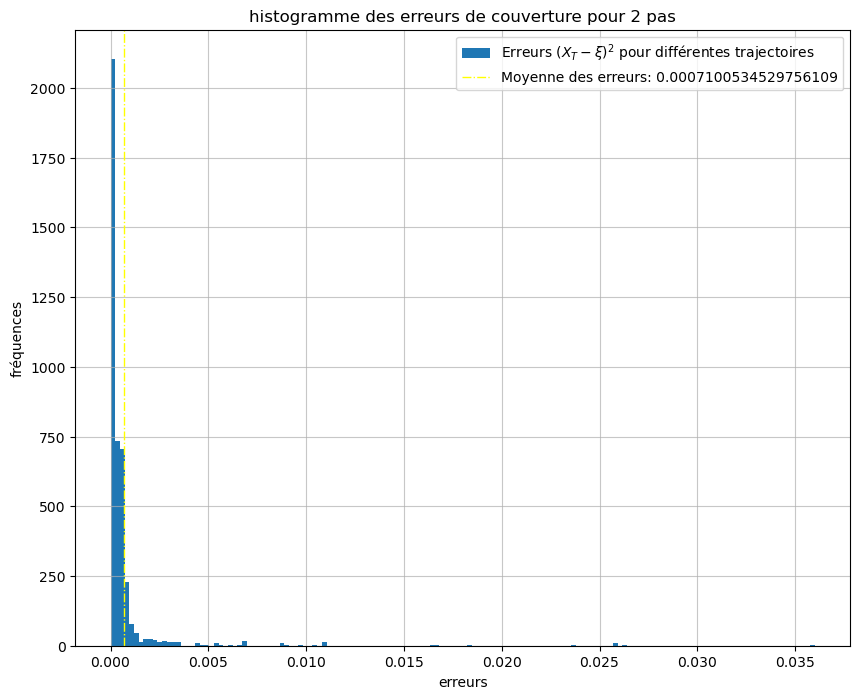

number of steps: 8

l'integrale de base est J_star = 0.0005357056494388801

L'intégrale interverti pour fubini est j_star_fubini = 0.0005357056494388803
la variance des erreurs est: 9.409645847363309e-06


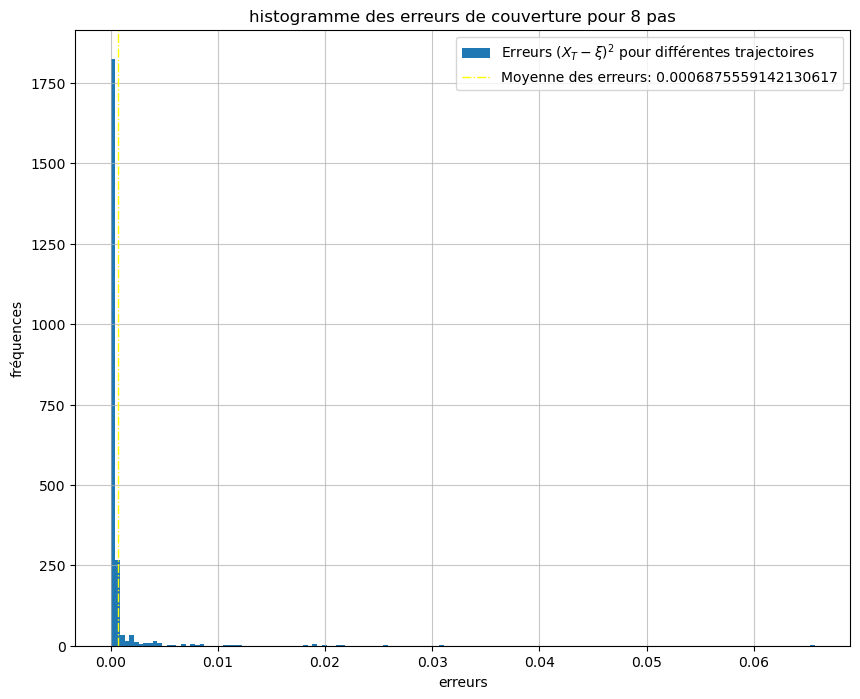

number of steps: 16

l'integrale de base est J_star = 0.0004328239733416715

L'intégrale interverti pour fubini est j_star_fubini = 0.0004328239733416713
la variance des erreurs est: 1.4618118952677675e-05


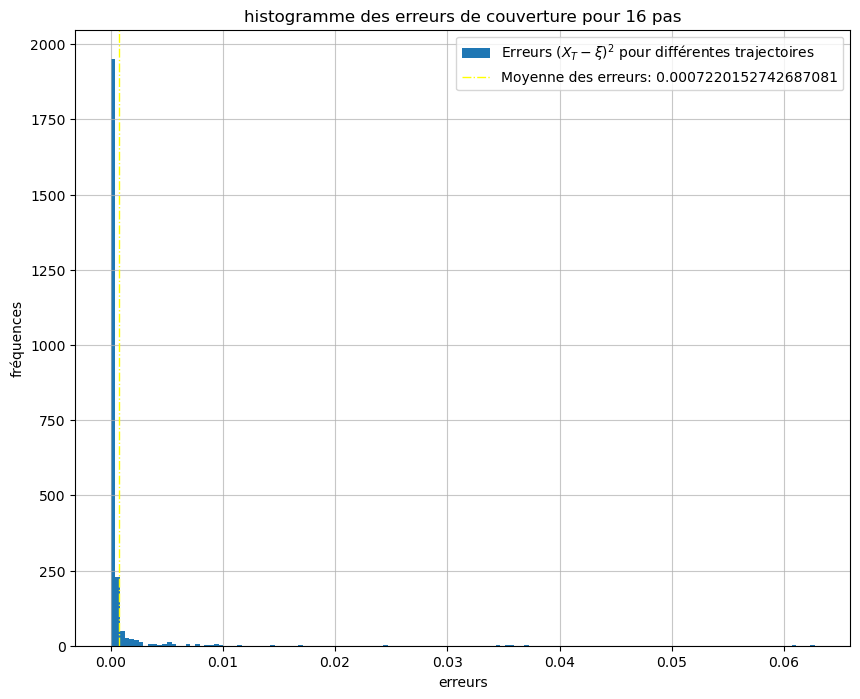

In [180]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[0]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

for n_steps in N_steps:
    
    print(f"number of steps: {n_steps}")  
    
    # On génère les trajectoires de St sur lesquelles on va appliquer les stratégies
    t_vec, V_paths, U_paths, Z_paths, S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps=n_steps, n_paths = n_paths, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
  
    
    hedging_simulation = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = hedging_simulation['X_paths']
    
    Z_hedghe_simulate = hedging_simulation['Z_paths']
    Zperp_paths = hedging_simulation['Zperp_paths']
    
    errors = compute_hedging_errors_direct(X_paths=X_paths, S_paths = S_paths, T1=T1, T2=T2, K=K_star)
    
    J_and_compagny = compute_optimal_J_value(S_paths=S_paths, V_paths=V_paths, Z_paths=Z_hedghe_simulate, Zperp_paths=Zperp_paths, T2=T2, rho=rho)
    
    J_star = J_and_compagny['J_star']
    J_star_fubini = J_and_compagny['J_star_fubini']
    J_per_path = J_and_compagny['J_per_path']
    
    print(f"\nl'integrale de base est J_star = {J_star}")
    
    print(f"\nL'intégrale interverti pour fubini est j_star_fubini = {J_star_fubini}")
    
    
    plt.figure(figsize=(10, 8))
    
    """
    plt.subplot(3, 1, 1)
    
    plt.hist(errors, density=True, label="erreurs approchées (direct) (XT - xi) de couverture", bins = 150)
    plt.axvline(x=np.mean(errors), color='black', linestyle=':', linewidth=1, label="espérance empirique")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.grid(True, alpha=0.7)
    
    plt.subplot(3, 1, 2)
    
    
    plt.hist(J_per_path, density=True, label="Valeurs de l'erreur pour différentes trajectoires", bins=50)
    plt.axvline(x=J_star, color='red', linestyle='--', linewidth=2, label=f"J_ star : {J_star}")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
   
   
    plt.subplot(3, 1, 3)
     """
    print(f"la variance des erreurs est: {np.var(errors**2)}")
    plt.hist(errors**2, density=True, label=r"Erreurs $(X_T - \xi)^2$ pour différentes trajectoires", bins=150)
    plt.axvline(x=np.mean(errors**2), color='yellow', linestyle='-.', linewidth=1, label=f"Moyenne des erreurs: {np.mean(errors**2)}")
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
    plt.grid(True, alpha=0.7)
    plt.show()
    

## Case 2

number of steps: 2



l'integrale de base est J_star = 0.0011236745176866592

L'intégrale interverti pour fubini est j_star_fubini = 0.001123674517686659
la variance des erreurs est: 3.2728976158243785e-05


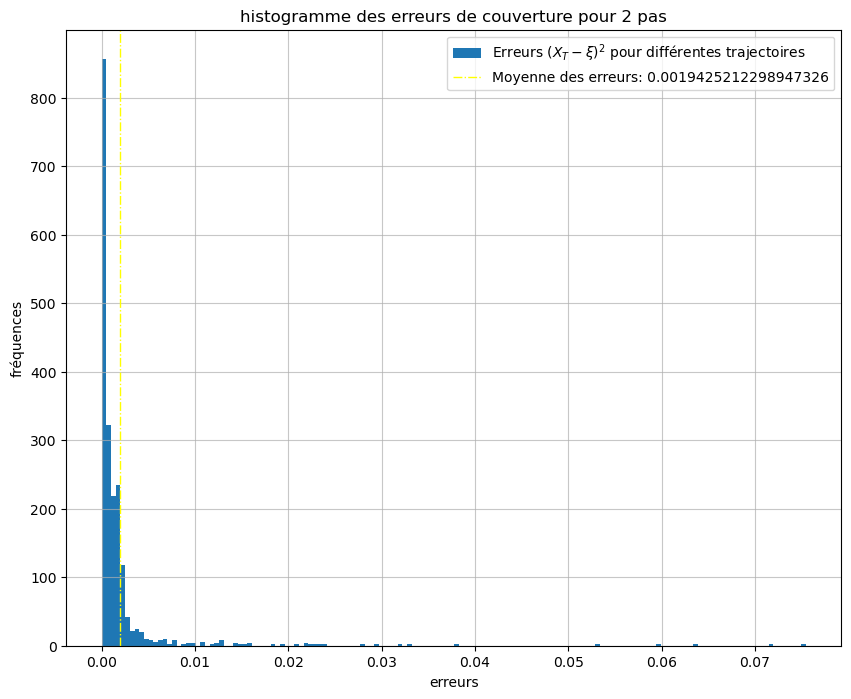

number of steps: 8

l'integrale de base est J_star = 0.0007840758519808381

L'intégrale interverti pour fubini est j_star_fubini = 0.0007840758519808378
la variance des erreurs est: 1.0439067662232574e-05


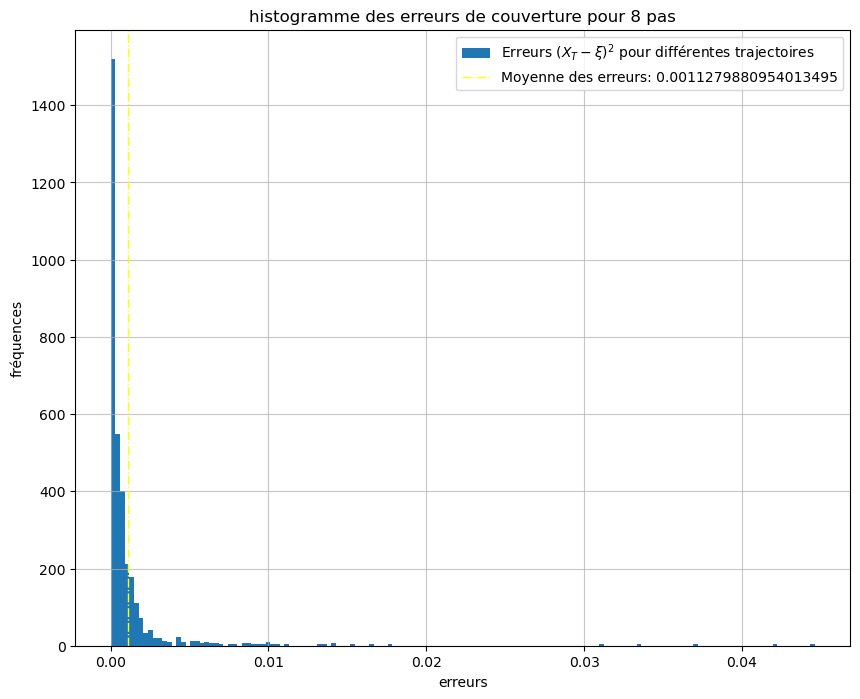

number of steps: 16

l'integrale de base est J_star = 0.00069735418610719

L'intégrale interverti pour fubini est j_star_fubini = 0.0006973541861071894
la variance des erreurs est: 5.538176455439664e-06


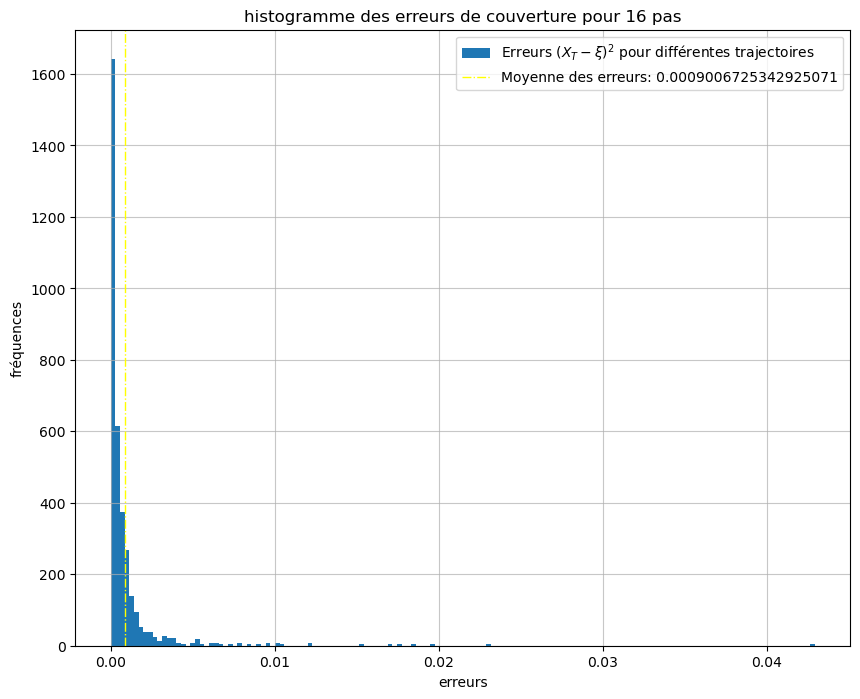

In [181]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[1]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

for n_steps in N_steps:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps=n_steps, n_paths = n_paths, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
   
    
    hedging_simulation = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = hedging_simulation['X_paths']
    
    Z_hedghe_simulate = hedging_simulation['Z_paths']
    Zperp_paths = hedging_simulation['Zperp_paths']
    
    errors = compute_hedging_errors_direct(X_paths=X_paths, S_paths = S_paths, T1=T1, T2=T2, K=K_star)
    
    J_and_compagny = compute_optimal_J_value(S_paths=S_paths, V_paths=V_paths, Z_paths=Z_hedghe_simulate, Zperp_paths=Zperp_paths, T2=T2, rho=rho)
    
    J_star = J_and_compagny['J_star']
    J_star_fubini = J_and_compagny['J_star_fubini']
    J_per_path = J_and_compagny['J_per_path']
    
    print(f"\nl'integrale de base est J_star = {J_star}")
    
    print(f"\nL'intégrale interverti pour fubini est j_star_fubini = {J_star_fubini}")
    
    
    plt.figure(figsize=(10, 8))
    
    """
    plt.subplot(3, 1, 1)
    
    plt.hist(errors, density=True, label="erreurs approchées (direct) (XT - xi) de couverture", bins = 150)
    plt.axvline(x=np.mean(errors), color='black', linestyle=':', linewidth=1, label="espérance empirique")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.grid(True, alpha=0.7)
    
    plt.subplot(3, 1, 2)
   
    
    plt.hist(J_per_path, density=True, label="erreurs théoriques au carrée", bins=50)
    plt.axvline(x=J_star, color='red', linestyle='--', linewidth=2, label=f"J_ star : {J_star}")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
 
    
    plt.subplot(3, 1, 3)
      """
    print(f"la variance des erreurs est: {np.var(errors**2)}")
    plt.hist(errors**2, density=True, label=r"Erreurs $(X_T - \xi)^2$ pour différentes trajectoires", bins=150)
    plt.axvline(x=np.mean(errors**2), color='yellow', linestyle='-.', linewidth=1, label=f"Moyenne des erreurs: {np.mean(errors**2)}")
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
    plt.grid(True, alpha=0.7)
    plt.show()
    

## Case 3

number of steps: 2

l'integrale de base est J_star = 0.008191543758617865

L'intégrale interverti pour fubini est j_star_fubini = 0.008191543758617865
la variance des erreurs est: 0.00011085381026337554


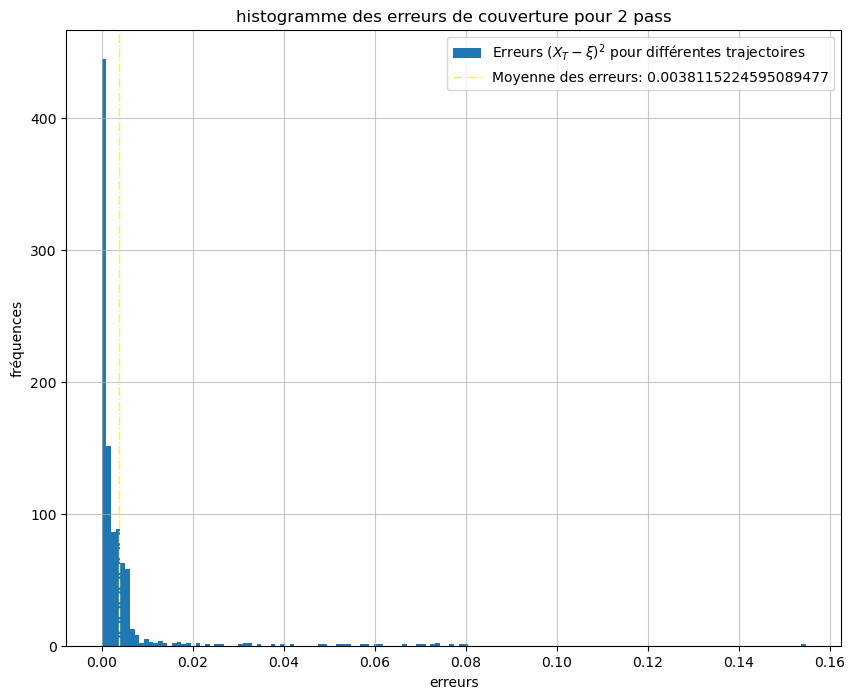

number of steps: 8

l'integrale de base est J_star = 0.004852223822450116

L'intégrale interverti pour fubini est j_star_fubini = 0.004852223822450111
la variance des erreurs est: 0.00028244918420448304


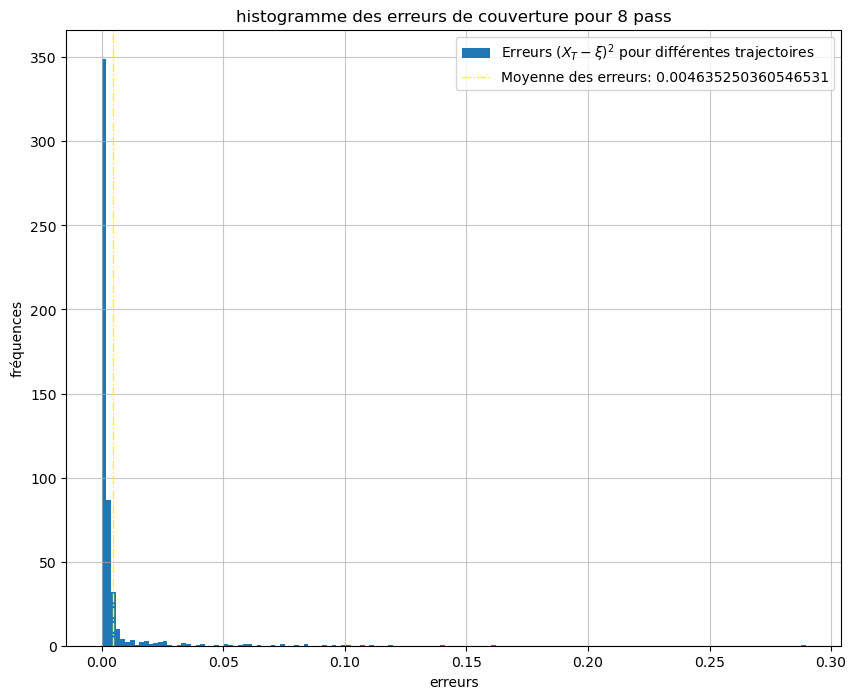

number of steps: 16

l'integrale de base est J_star = 0.003390248446347026

L'intégrale interverti pour fubini est j_star_fubini = 0.003390248446347017
la variance des erreurs est: 0.0004378061496948818


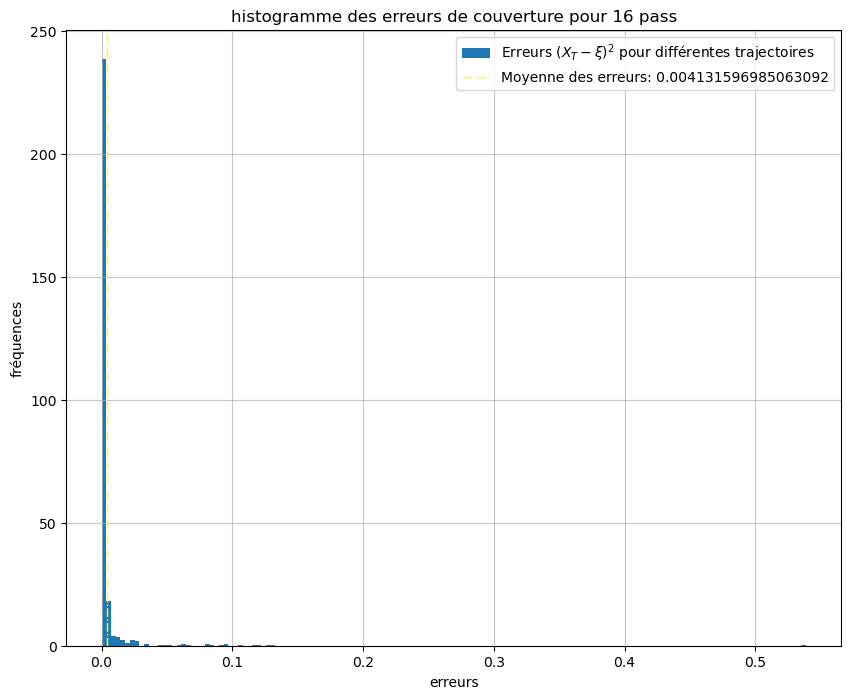

In [182]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[2]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

for n_steps in N_steps:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps=n_steps, n_paths = n_paths, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
   
    
    hedging_simulation = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = hedging_simulation['X_paths']
    
    Z_hedghe_simulate = hedging_simulation['Z_paths']
    Zperp_paths = hedging_simulation['Zperp_paths']
    
    errors = compute_hedging_errors_direct(X_paths=X_paths, S_paths = S_paths, T1=T1, T2=T2, K=K_star)
    
    J_and_compagny = compute_optimal_J_value(S_paths=S_paths, V_paths=V_paths, Z_paths=Z_hedghe_simulate, Zperp_paths=Zperp_paths, T2=T2, rho=rho)
    
    J_star = J_and_compagny['J_star']
    J_star_fubini = J_and_compagny['J_star_fubini']
    J_per_path = J_and_compagny['J_per_path']
    
    print(f"\nl'integrale de base est J_star = {J_star}")
    
    print(f"\nL'intégrale interverti pour fubini est j_star_fubini = {J_star_fubini}")
    
    
    plt.figure(figsize=(10, 8))
    
    """
    plt.subplot(3, 1, 1)
    
    plt.hist(errors, density=True, label="erreurs approchées (direct) (XT - xi) de couverture", bins = 150)
    plt.axvline(x=np.mean(errors), color='black', linestyle=':', linewidth=1, label="espérance empirique")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.grid(True, alpha=0.7)
    
    plt.subplot(3, 1, 2)
   
    
    plt.hist(J_per_path, density=True, label="valeurs de J_star pour différentes trajectoires", bins=50)
    plt.axvline(x=J_star, color='red', linestyle='--', linewidth=2, label=f"J_ star : {J_star}")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pass")
   
    
    plt.subplot(3, 1, 3)
    """
    print(f"la variance des erreurs est: {np.var(errors**2)}")
    plt.hist(errors**2, density=True, label=r"Erreurs $(X_T - \xi)^2$ pour différentes trajectoires", bins=150)
    
    plt.axvline(x=np.mean(errors**2), color='yellow', linestyle='-.', linewidth=1, label=f"Moyenne des erreurs: {np.mean(errors**2)}")
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pass")
    plt.grid(True, alpha=0.7)
    plt.show()
    

## Case 4

number of steps: 2

l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 6.869167836184152e-06


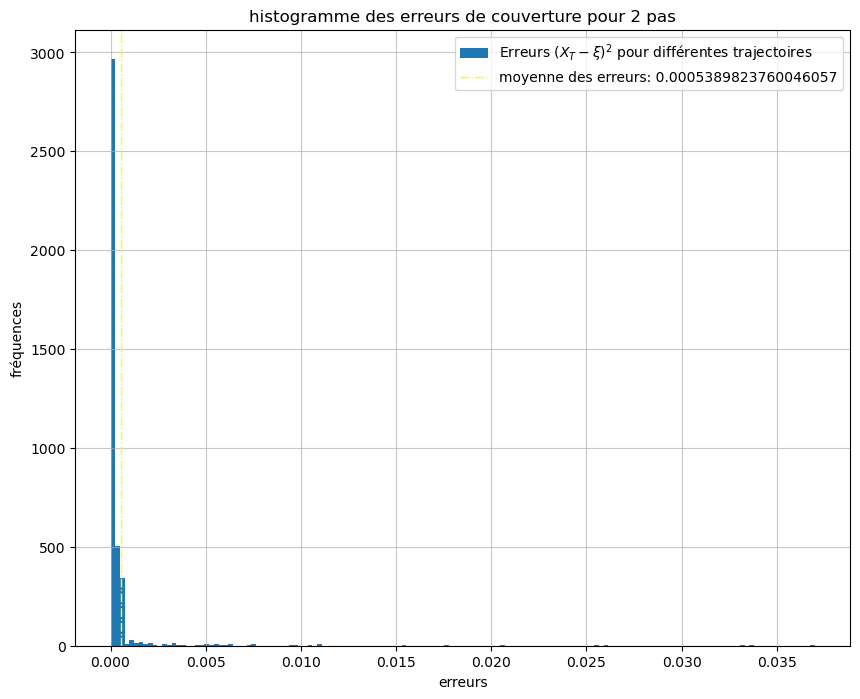

number of steps: 8

l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 1.0602153588035227e-05


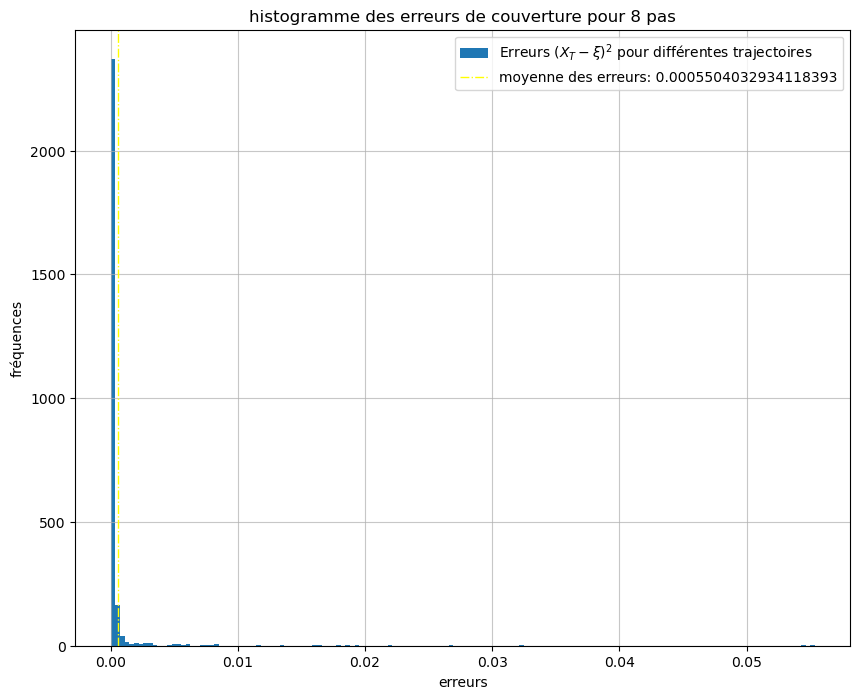

number of steps: 16


/tmp/ipykernel_4673/331022045.py:105: IntegrationWarning: The maximum number of subdivisions (5000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)
/tmp/ipykernel_4673/331022045.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)



l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 1.7466136307491256e-05


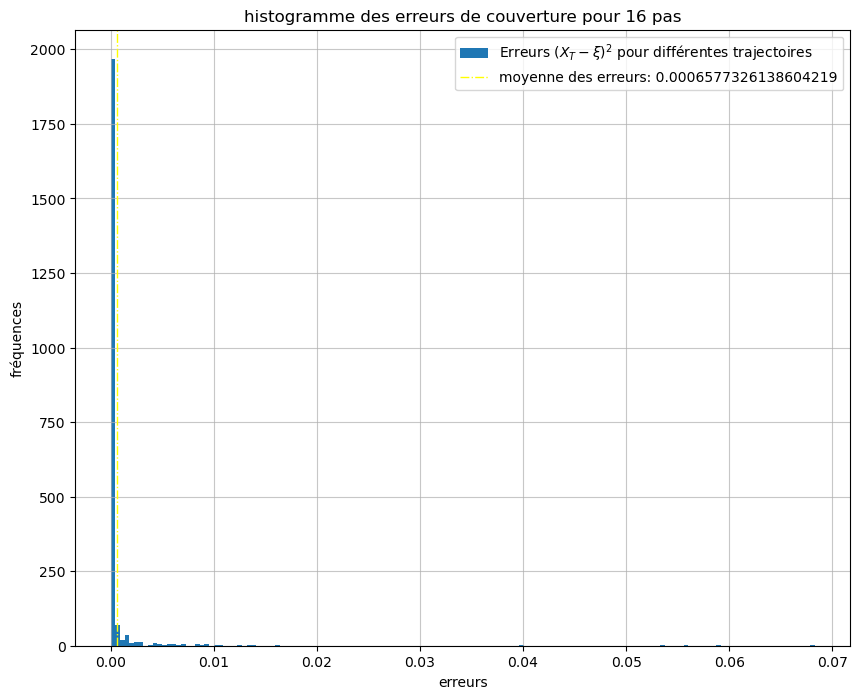

In [183]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[3]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

for n_steps in N_steps:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps=n_steps, n_paths = n_paths, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
   
    
    hedging_simulation = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = hedging_simulation['X_paths']
    
    Z_hedghe_simulate = hedging_simulation['Z_paths']
    Zperp_paths = hedging_simulation['Zperp_paths']
    
    errors = compute_hedging_errors_direct(X_paths=X_paths, S_paths = S_paths, T1=T1, T2=T2, K=K_star)
    
    J_and_compagny = compute_optimal_J_value(S_paths=S_paths, V_paths=V_paths, Z_paths=Z_hedghe_simulate, Zperp_paths=Zperp_paths, T2=T2, rho=rho)
    
    J_star = J_and_compagny['J_star']
    J_star_fubini = J_and_compagny['J_star_fubini']
    J_per_path = J_and_compagny['J_per_path']
    
    print(f"\nl'integrale de base est J_star = {J_star}")
    
    print(f"\nL'intégrale interverti pour fubini est j_star_fubini = {J_star_fubini}")
    
    
    plt.figure(figsize=(10, 8))
    
    """
    plt.subplot(3, 1, 1)
    
    plt.hist(errors, density=True, label="erreurs approchées (direct) (XT - xi) de couverture", bins = 150)
    plt.axvline(x=np.mean(errors), color='black', linestyle=':', linewidth=1, label="espérance empirique")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.grid(True, alpha=0.7)
    
    plt.subplot(3, 1, 2)
    """
    """
    print(f"first Values of (XT - xi) squared: {J_per_path[:80]}")
    plt.hist(J_per_path, density=True, label="erreurs théoriques au carrée", bins=50)
    plt.axvline(x=J_star, color='red', linestyle='--', linewidth=2, label=f"J_ star : {J_star}")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
   
    
    plt.subplot(3, 1, 3)
    """
    #print(f"first Values of (XT - xi) squared: {(errors[:80])**2}")
    print(f"la variance des erreurs est: {np.var(errors**2)}")
    errors_mean = np.mean(errors**2)
    plt.hist(errors**2, density=True, label=r"Erreurs $(X_T - \xi)^2$ pour différentes trajectoires", bins=150)
    plt.axvline(x=errors_mean, color='yellow', linestyle='-.', linewidth=1, label=f"moyenne des erreurs: {errors_mean}")
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
    plt.grid(True, alpha=0.7)
    plt.show()
    

## Case 5

number of steps: 2

l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 2.592925173190596e-05


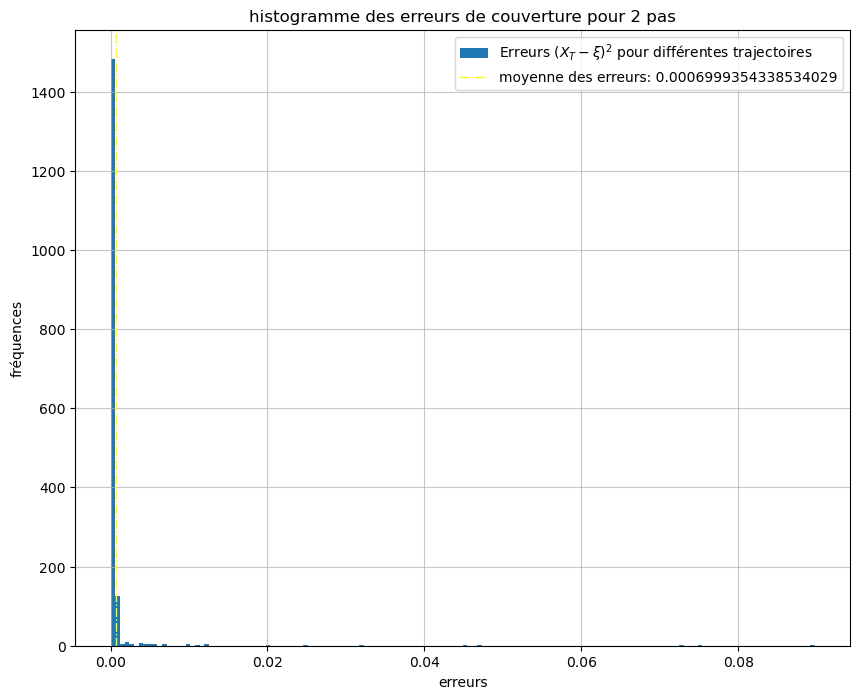

number of steps: 8

l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 5.118122733713857e-05


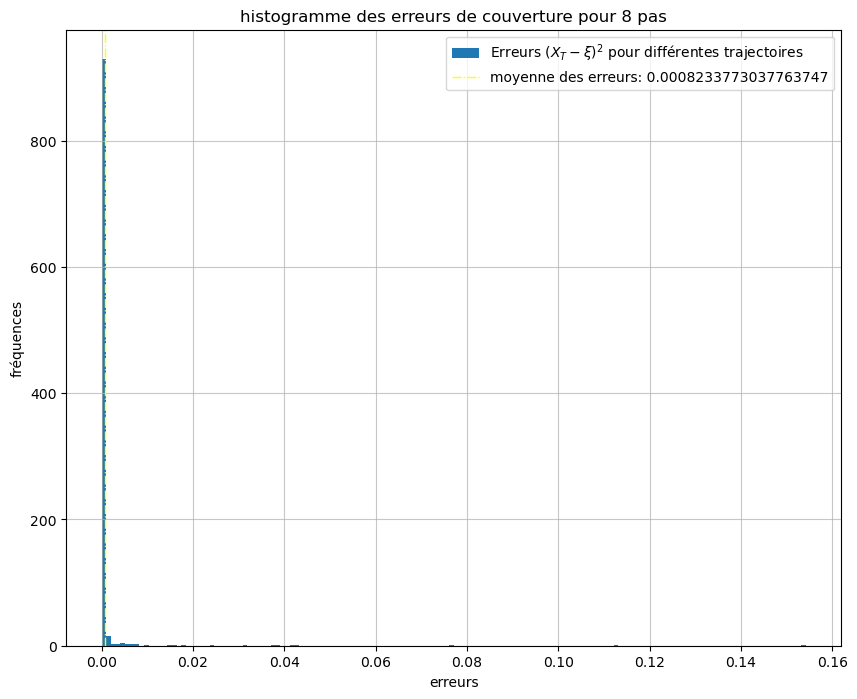

number of steps: 16


/tmp/ipykernel_4673/331022045.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)
/tmp/ipykernel_4673/331022045.py:105: IntegrationWarning: The maximum number of subdivisions (5000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=5000, epsabs=1e-8, epsrel=1e-8)



l'integrale de base est J_star = 0.0

L'intégrale interverti pour fubini est j_star_fubini = 0.0
la variance des erreurs est: 0.00024003498194983232


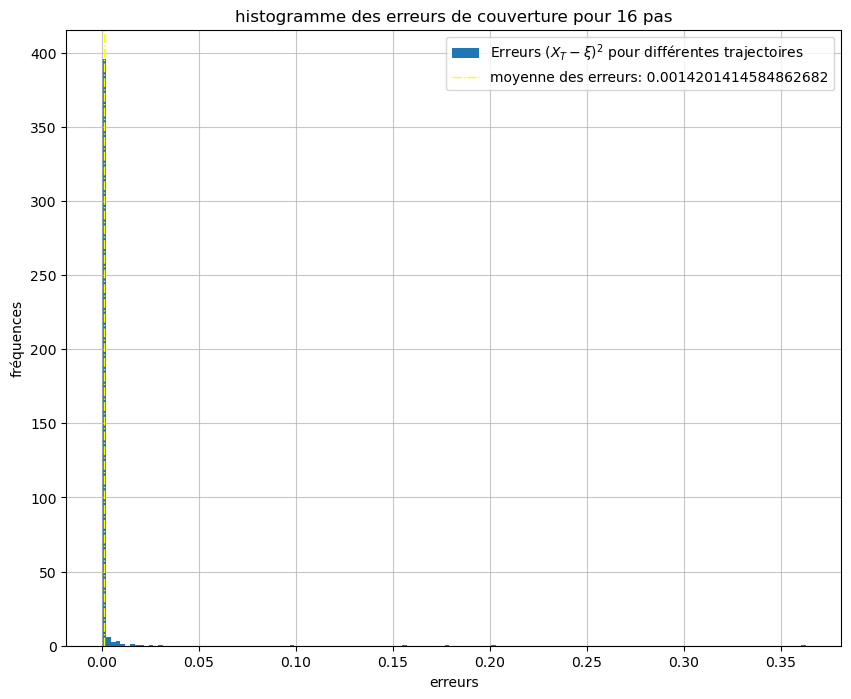

In [184]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[4]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

for n_steps in N_steps:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps=n_steps, n_paths = n_paths, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
   
    
    hedging_simulation = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = hedging_simulation['X_paths']
    
    Z_hedghe_simulate = hedging_simulation['Z_paths']
    Zperp_paths = hedging_simulation['Zperp_paths']
    
    errors = compute_hedging_errors_direct(X_paths=X_paths, S_paths = S_paths, T1=T1, T2=T2, K=K_star)
    
    J_and_compagny = compute_optimal_J_value(S_paths=S_paths, V_paths=V_paths, Z_paths=Z_hedghe_simulate, Zperp_paths=Zperp_paths, T2=T2, rho=rho)
    
    J_star = J_and_compagny['J_star']
    J_star_fubini = J_and_compagny['J_star_fubini']
    J_per_path = J_and_compagny['J_per_path']
    
    print(f"\nl'integrale de base est J_star = {J_star}")
    
    print(f"\nL'intégrale interverti pour fubini est j_star_fubini = {J_star_fubini}")
    
    
    plt.figure(figsize=(10, 8))
    
    """
    plt.subplot(3, 1, 1)
    
    plt.hist(errors, density=True, label="erreurs approchées (direct) (XT - xi) de couverture", bins = 150)
    plt.axvline(x=np.mean(errors), color='black', linestyle=':', linewidth=1, label="espérance empirique")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.grid(True, alpha=0.7)
    
    plt.subplot(3, 1, 2)
    """
    """
    plt.hist(J_per_path, density=True, label="erreurs théoriques au carrée", bins=50)
    plt.axvline(x=J_star, color='red', linestyle='--', linewidth=2, label=f"J_ star : {J_star}")
    
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
   
    
    plt.subplot(3, 1, 3)
    """
    #print(f"first Values of (XT - xi) squared: {(errors[:80])**2}")
    print(f"la variance des erreurs est: {np.var(errors**2)}")
    errors_mean = np.mean(errors**2)
    plt.hist(errors**2, density=True, label=r"Erreurs $(X_T - \xi)^2$ pour différentes trajectoires", bins=150)
    plt.axvline(x=errors_mean, color='yellow', linestyle='-.', linewidth=1, label=f"moyenne des erreurs: {errors_mean}")
    plt.legend()
    plt.xlabel("erreurs")
    plt.ylabel("fréquences")
    plt.title(f"histogramme des erreurs de couverture pour {n_steps} pas")
    plt.grid(True, alpha=0.7)
    plt.show()
    

# Values of hedging portfolio through time

## Case 1

number of steps: 8


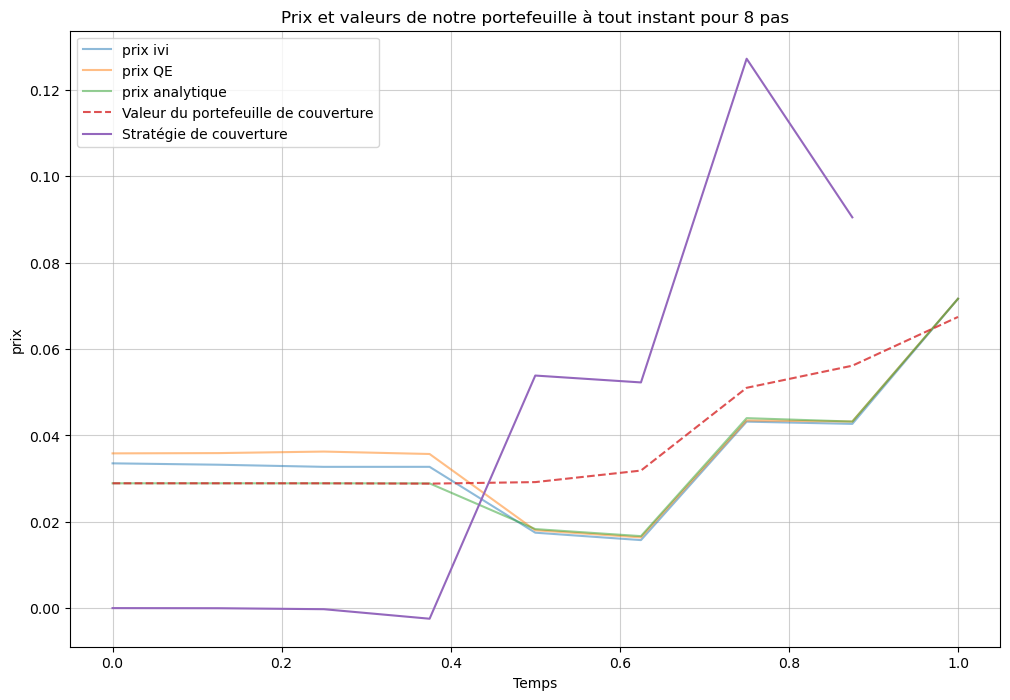

number of steps: 16


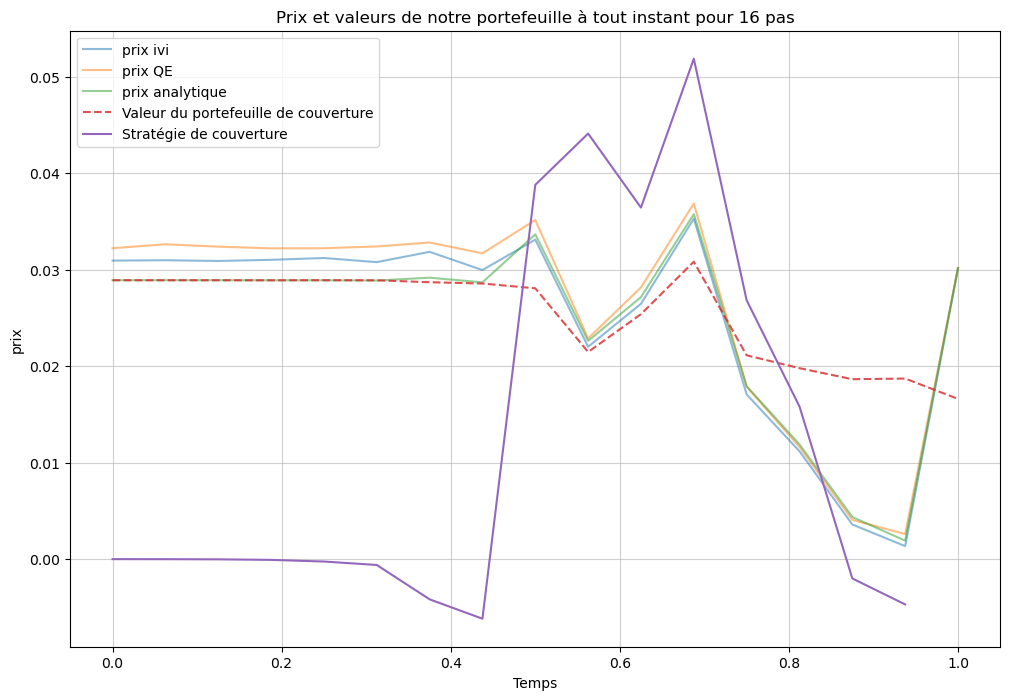

In [185]:
# ENFORCE T =  1. first 
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[0]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0
for n_steps in N_steps[1:]:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps, n_paths = 1, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices, QE_prices, analytic_prices = prices_over_the_traj(t_vec=t_vec, V_paths=V_paths, U_paths=U_paths, Z_paths=Z_paths,
                                                                  S_paths=S_paths, n_steps=n_steps, a=a, b=b, c=c, rho=rho,
                                                                  T2=T2, T1=T1, n_paths=50000, K_star=K_star)
    ivi_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    QE_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    analytic_prices.append(np.maximum(S_paths[-1, 0]/S_T1- K_star, 0))
    
    strategy = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    X_paths = strategy['X_paths']
    #Z_hedging_paths = strategy['Z_paths']
    #Z_perp_hedging_paths = strategy['Z_perp_paths']
    alpha_paths = strategy['alpha_paths']
    plt.figure(figsize=(12, 8))
    
    plt.plot(t_vec, ivi_prices, label="prix ivi", alpha = 0.5)
    plt.plot(t_vec, QE_prices, label="prix QE", alpha = 0.5)
    plt.plot(t_vec, analytic_prices, label="prix analytique", alpha = 0.5)
    plt.plot(t_vec, X_paths, label="Valeur du portefeuille de couverture",  linestyle='--', alpha = 0.8)
    plt.plot(t_vec[:-1], alpha_paths, label="Stratégie de couverture")
    
    plt.xlabel("Temps")
    plt.ylabel("prix")
    
    plt.title(f"Prix et valeurs de notre portefeuille à tout instant pour {n_steps} pas")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

## Case 2

number of steps: 8


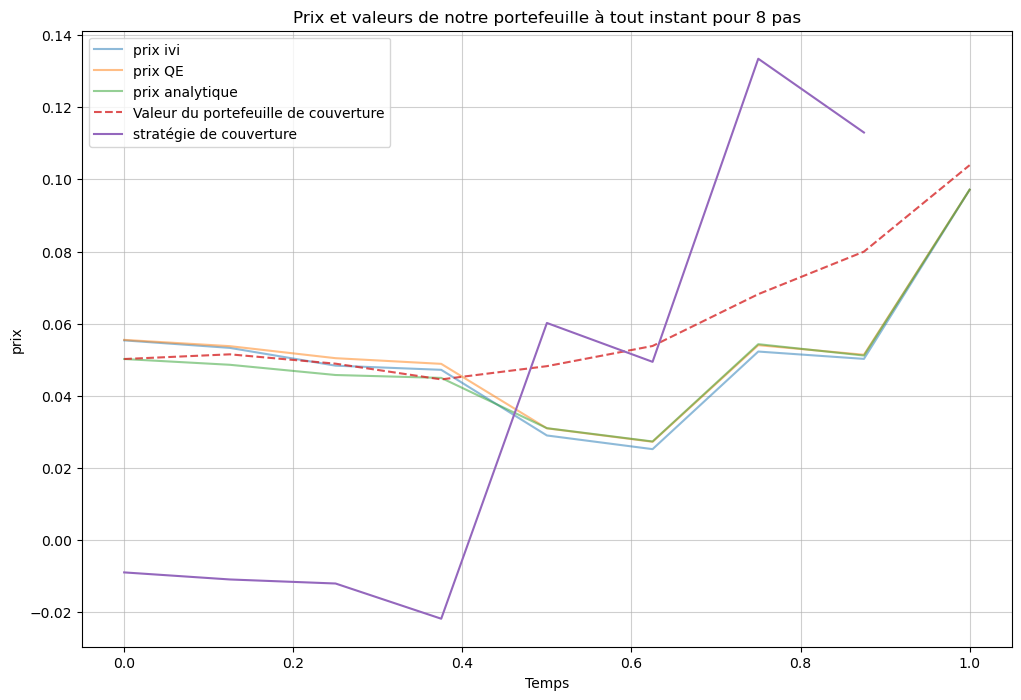

number of steps: 16


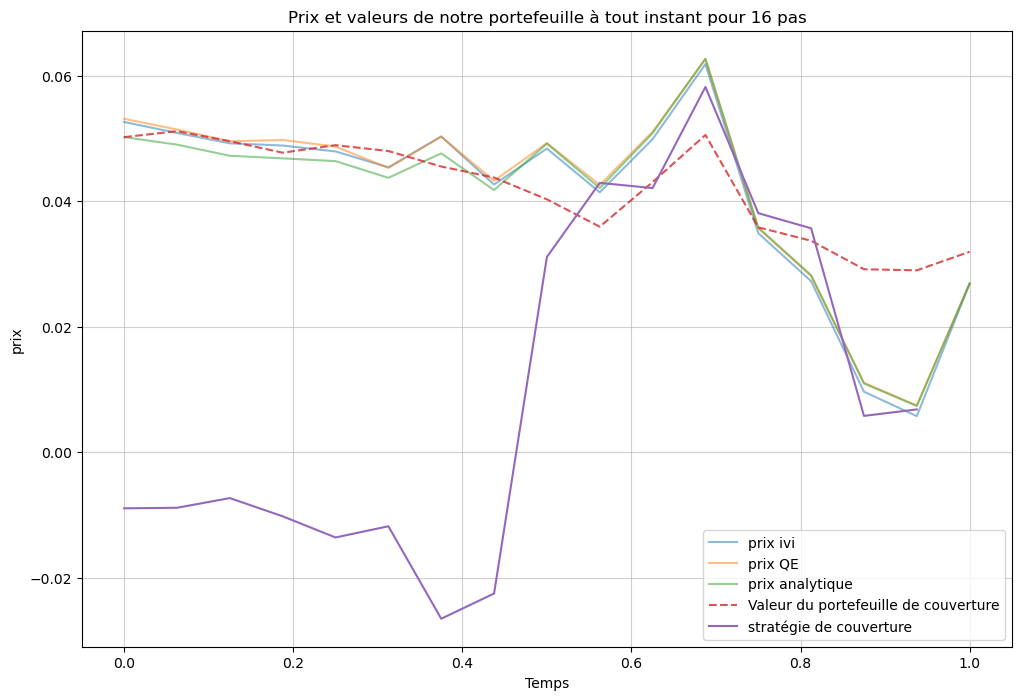

In [186]:
# ENFORCE T =  1. first 
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[1]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0
for n_steps in N_steps[1:]:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps, n_paths = 1, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices, QE_prices, analytic_prices = prices_over_the_traj(t_vec=t_vec, V_paths=V_paths, U_paths=U_paths, Z_paths=Z_paths,
                                                                  S_paths=S_paths, n_steps=n_steps, a=a, b=b, c=c, rho=rho,
                                                                  T2=T2, T1=T1, n_paths=50000, K_star=K_star)
    ivi_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    QE_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    analytic_prices.append(np.maximum(S_paths[-1, 0]/S_T1- K_star, 0))
    
    strategy = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    X_paths = strategy['X_paths']
    #Z_hedging_paths = strategy['Z_paths']
    #Z_perp_hedging_paths = strategy['Z_perp_paths']
    alpha_paths = strategy['alpha_paths']
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(t_vec, ivi_prices, label="prix ivi", alpha = 0.5)
    plt.plot(t_vec, QE_prices, label="prix QE", alpha = 0.5)
    plt.plot(t_vec, analytic_prices, label="prix analytique", alpha = 0.5)
    plt.plot(t_vec, X_paths, label="Valeur du portefeuille de couverture",  linestyle='--', alpha = 0.8)
    plt.plot(t_vec[: -1], alpha_paths, label="stratégie de couverture")
    
    plt.xlabel("Temps")
    plt.ylabel("prix")
    
    plt.title(f"Prix et valeurs de notre portefeuille à tout instant pour {n_steps} pas")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

## Case 3

number of steps: 8


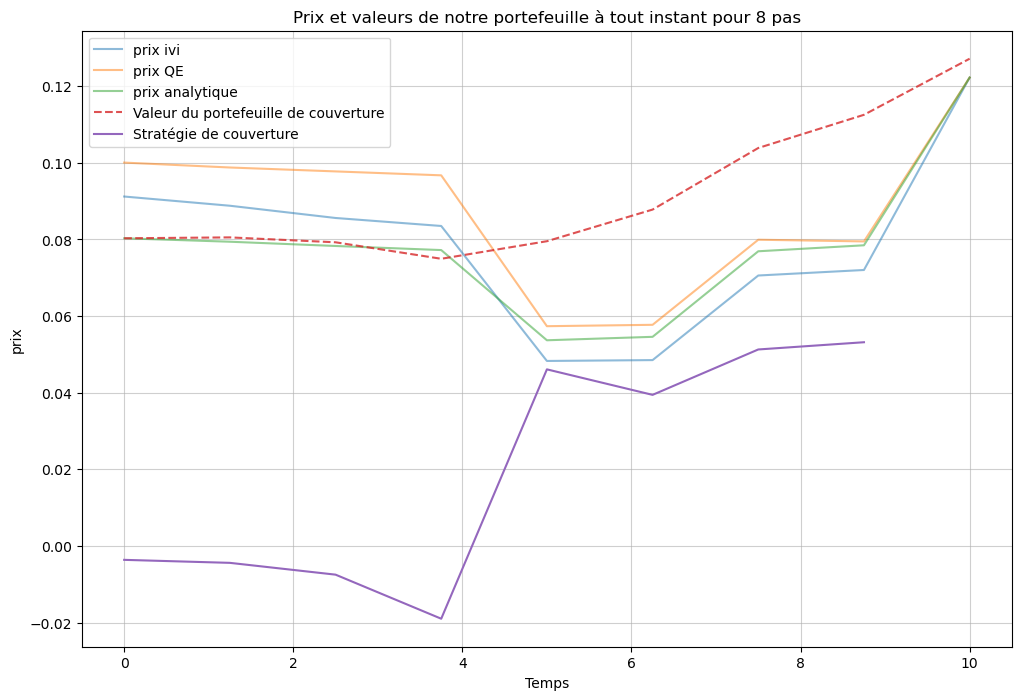

number of steps: 16


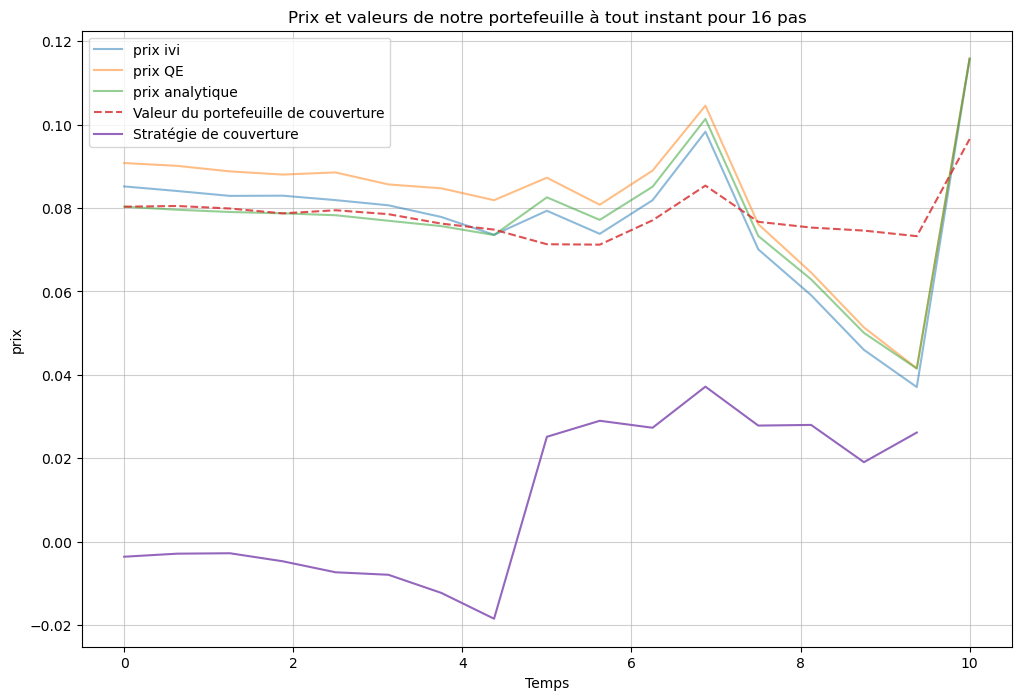

In [187]:
# ENFORCE T =  1. first 
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[2]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0
for n_steps in N_steps[1:]:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps, n_paths = 1, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices, QE_prices, analytic_prices = prices_over_the_traj(t_vec=t_vec, V_paths=V_paths, U_paths=U_paths, Z_paths=Z_paths,
                                                                  S_paths=S_paths, n_steps=n_steps, a=a, b=b, c=c, rho=rho,
                                                                  T2=T2, T1=T1, n_paths=50000, K_star=K_star)
    ivi_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    QE_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    analytic_prices.append(np.maximum(S_paths[-1, 0]/S_T1- K_star, 0))
    
    strategy = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = strategy['X_paths']
    #Z_hedging_paths = strategy['Z_paths']
    #Z_perp_hedging_paths = strategy['Z_perp_paths']
    alpha_paths = strategy['alpha_paths']
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(t_vec, ivi_prices, label="prix ivi", alpha = 0.5)
    plt.plot(t_vec, QE_prices, label="prix QE", alpha = 0.5)
    plt.plot(t_vec, analytic_prices, label="prix analytique", alpha = 0.5)
    plt.plot(t_vec, X_paths, label="Valeur du portefeuille de couverture",  linestyle='--', alpha = 0.8)
    plt.plot(t_vec[:-1], alpha_paths, label="Stratégie de couverture")
    
    plt.xlabel("Temps")
    plt.ylabel("prix")
    
    plt.title(f"Prix et valeurs de notre portefeuille à tout instant pour {n_steps} pas")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

## Case 4

number of steps: 8


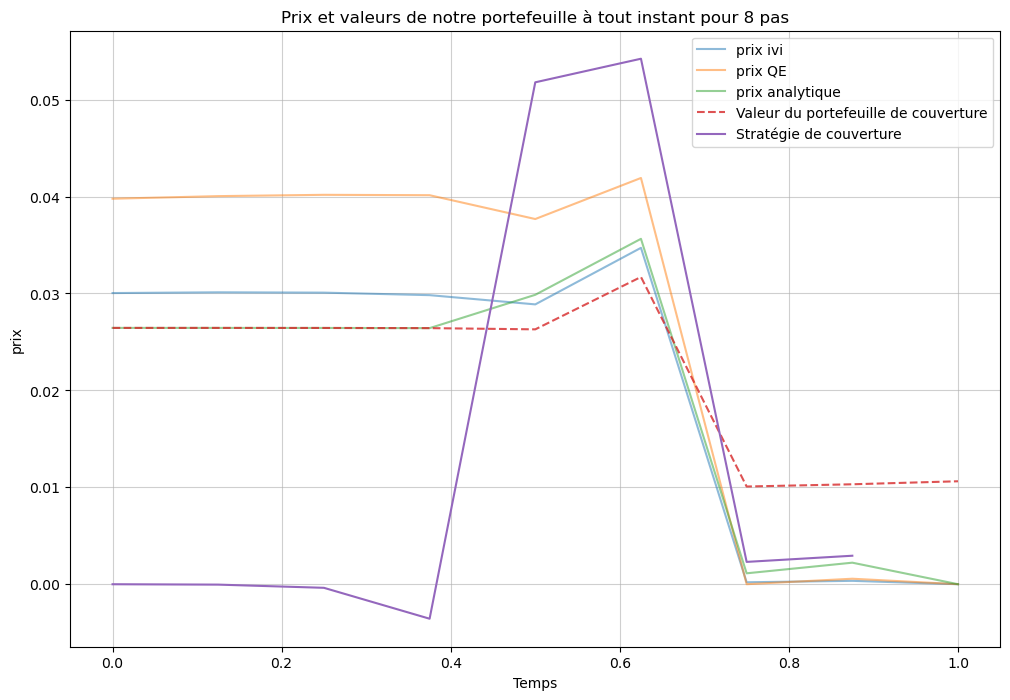

number of steps: 16


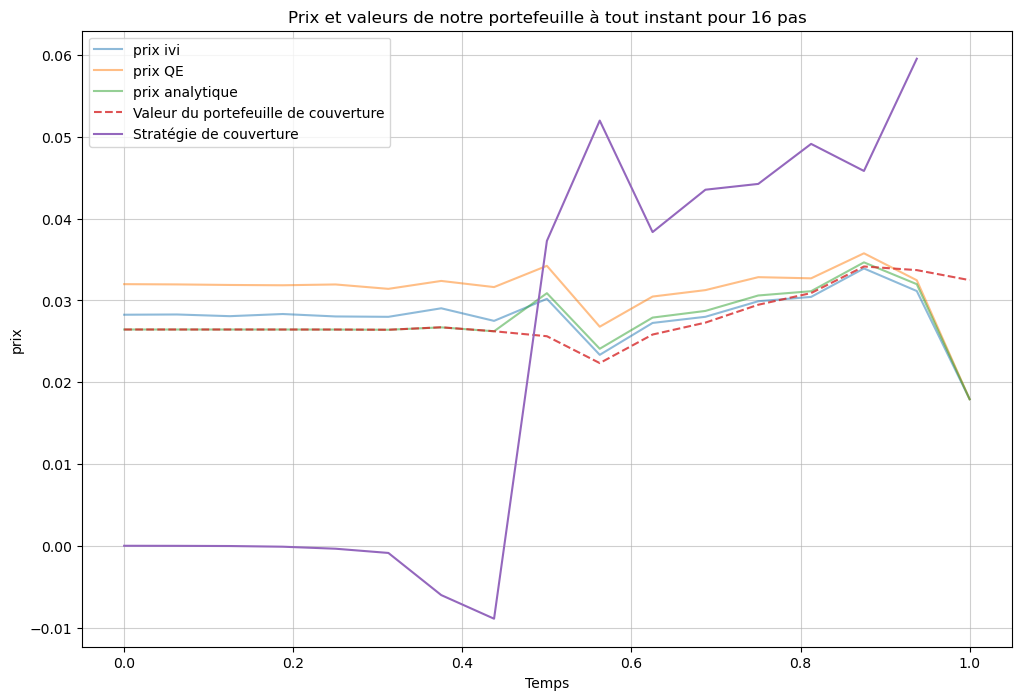

In [188]:
# ENFORCE T =  1. first 
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[3]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0
for n_steps in N_steps[1:]:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps, n_paths = 1, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices, QE_prices, analytic_prices = prices_over_the_traj(t_vec=t_vec, V_paths=V_paths, U_paths=U_paths, Z_paths=Z_paths,
                                                                  S_paths=S_paths, n_steps=n_steps, a=a, b=b, c=c, rho=rho,
                                                                  T2=T2, T1=T1, n_paths=50000, K_star=K_star)
    ivi_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    QE_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    analytic_prices.append(np.maximum(S_paths[-1, 0]/S_T1- K_star, 0))
    
    strategy = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = strategy['X_paths']
    #Z_hedging_paths = strategy['Z_paths']
    #Z_perp_hedging_paths = strategy['Z_perp_paths']
    alpha_paths = strategy['alpha_paths']
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(t_vec, ivi_prices, label="prix ivi", alpha = 0.5)
    plt.plot(t_vec, QE_prices, label="prix QE", alpha = 0.5)
    plt.plot(t_vec, analytic_prices, label="prix analytique", alpha = 0.5)
    plt.plot(t_vec, X_paths, label="Valeur du portefeuille de couverture",  linestyle='--', alpha = 0.8)
    plt.plot(t_vec[:-1], alpha_paths, label="Stratégie de couverture")
    
    plt.xlabel("Temps")
    plt.ylabel("prix")
    
    plt.title(f"Prix et valeurs de notre portefeuille à tout instant pour {n_steps} pas")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

## Case 5

number of steps: 8


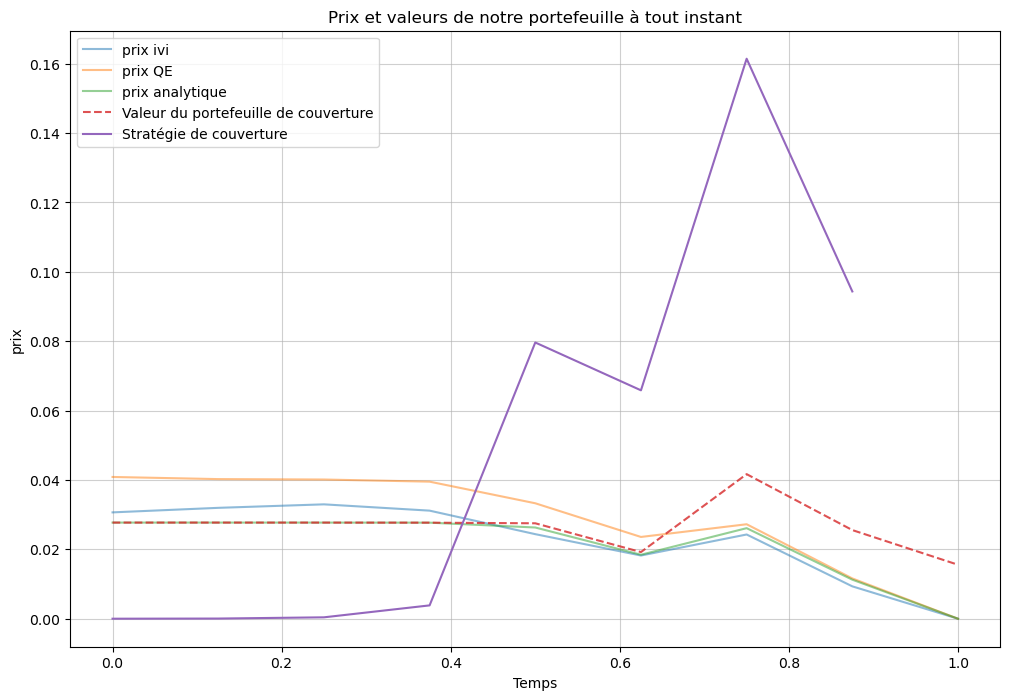

number of steps: 16


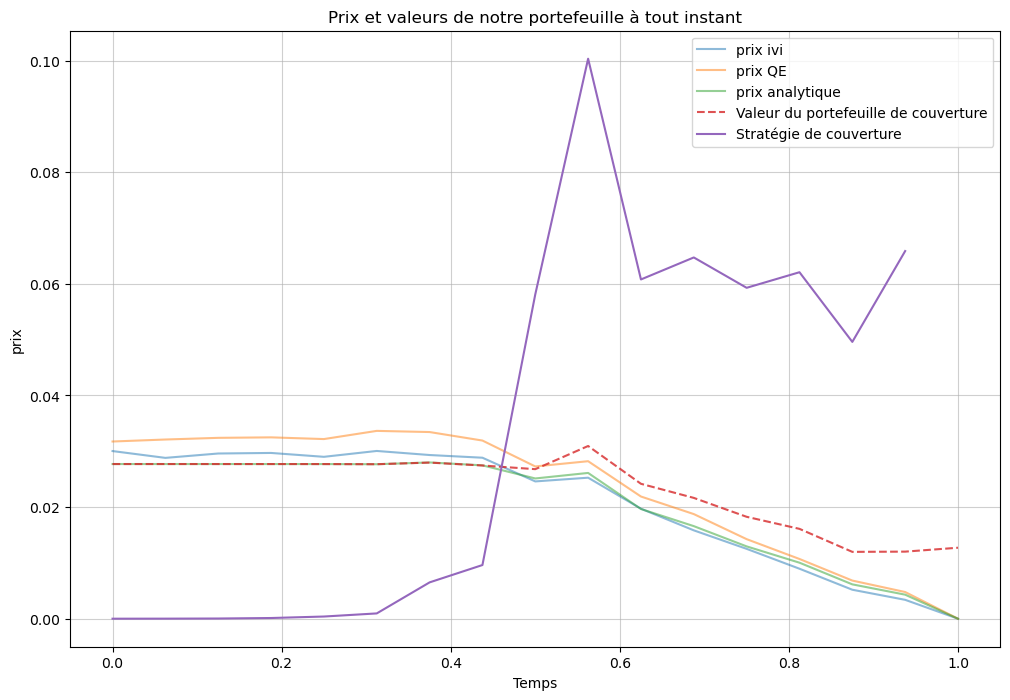

In [189]:
# ENFORCE T =  1. first 
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[4]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0
for n_steps in N_steps[1:]:
    
    print(f"number of steps: {n_steps}") 
    
    # On génère une trajectoire de St sur laquelle on va calculer tous nos prix
    t_vec, V_paths, U_paths, Z_paths , S_paths = simulate_paths(a, b, c, rho, V_0, T2, n_steps, n_paths = 1, S_0 = S_0)
    
    dt = T2/n_steps
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices, QE_prices, analytic_prices = prices_over_the_traj(t_vec=t_vec, V_paths=V_paths, U_paths=U_paths, Z_paths=Z_paths,
                                                                  S_paths=S_paths, n_steps=n_steps, a=a, b=b, c=c, rho=rho,
                                                                  T2=T2, T1=T1, n_paths=50000, K_star=K_star)
    ivi_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    QE_prices.append(np.maximum(S_paths[-1, 0]/S_T1 - K_star, 0))
    analytic_prices.append(np.maximum(S_paths[-1, 0]/S_T1- K_star, 0))
    
    strategy = simulate_hedging_strategy(S_paths=S_paths, V_paths=V_paths, T1=T1, T2=T2, K=K_star, kappa=kappa,
                                        theta=theta, sigma=sigma, rho=rho)
    
    X_paths = strategy['X_paths']
    #Z_hedging_paths = strategy['Z_paths']
    #Z_perp_hedging_paths = strategy['Z_perp_paths']
    alpha_paths = strategy['alpha_paths']
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(t_vec, ivi_prices, label="prix ivi", alpha = 0.5)
    plt.plot(t_vec, QE_prices, label="prix QE", alpha = 0.5)
    plt.plot(t_vec, analytic_prices, label="prix analytique", alpha = 0.5)
    plt.plot(t_vec, X_paths, label="Valeur du portefeuille de couverture",  linestyle='--', alpha = 0.8)
    plt.plot(t_vec[:-1], alpha_paths, label="Stratégie de couverture")
    
    plt.xlabel("Temps")
    plt.ylabel("prix")
    
    plt.title("Prix et valeurs de notre portefeuille à tout instant")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()